In [ ]:
# Standard library
import random
import copy
import json
import glob

# Specific import from standard library
from collections import defaultdict, Counter
from pathlib import Path

# Basic data libraries
import numpy as np
import pandas as pd

# Kaggle
import kaggle_environments
from kaggle_environments import evaluate, make, utils

# Interactivity
import ipywidgets as widgets
from ipywidgets import interactive, interact
from ipywidgets import IntSlider, interact_manual

# Graphs
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.animation import FuncAnimation, PillowWriter
from PIL import Image

# Progress bar
from tqdm.auto import tqdm

In [ ]:
# Default graph settings

# Seaborn advanced                                                                                                                                                           
sns.set(style='ticks',          # 'ticks', 'darkgrid'                                                                                                                        
        palette='colorblind',   # 'colorblind', 'pastel', 'muted', 'bright'                                                                                                  
        #palette=sns.color_palette('Accent'),   # 'Set1', 'Set2', 'Dark2', 'Accent'                                                                                          
        rc = {                                                                                                                                                               
           'figure.autolayout': False,   # Automaticall set the figure size to fit in canvas                                                                       
           'figure.figsize': (16, 10),   # Figure size - width, height (in inches)    
           'figure.max_open_warning': False,
           'figure.titlesize': 32,      # Whole figure title size (plt.suptitle)
           'legend.frameon': True,      # Frame around the legend                                                                                                              
           'patch.linewidth': 2.0,      # Width of frame around the legend                                                                                                        
           'lines.markersize': 6,       # Size of marker points                                                                                                                      
           'lines.linewidth': 2.0,      # Width of lines                                                                                                                      
           'font.size': 14,             # Size of font on axes values                                                                                                           
           'legend.fontsize': 18,       # Font size in the legend                                                                                                           
           'axes.labelsize': 22,        # Font size of axes names                                                                                                                  
           'axes.titlesize': 26,        # Font size of subplot titles (plt.title)                                                                                                                 
           'axes.grid': True,           # Set grid on/off                                                                                                                             
           'grid.color': '0.9',         # Color of grid lines - 1 = white, 0 = black                                                                                          
           'grid.linestyle': '-',       # Style of grid lines                                                                                                              
           'grid.linewidth': 1.0,       # Width of grid lines                                                                                                                
           'xtick.labelsize': 22,       # Font size of values on X-axis                                                                                                  
           'ytick.labelsize': 22,       # Font size of values on Y-axis                                                                                                       
           'xtick.major.size': 8,       # Size of ticks on X-axis                                                                                                    
           'ytick.major.size': 8,       # Size of ticks on Y-axis                                                                                                 
           'xtick.major.pad': 10.0,     # Distance of axis values from X-axis                                                                                               
           'ytick.major.pad': 10.0,     # Distance of axis values from Y-axis   
           'image.cmap': 'viridis'      # Default colormap
           }                                                                                                                                                                 
       )

# Strategy

## Adjusting law of large numbers - Assumed original probability

If every machine gave a reward with a random probability that does not change, it would be easy to find out the probability. However the probability does change, so it is a bit more difficult. I was thinking about it whole evening and googled, but just could not find anything. Anyway, the problem still seemed solvable and I did not go sleep until I solved it.

If the probability does not change, how do we estimate it? We pull the machine a couple of times, the more times the better estimate, and according to law of large numbers "the sample average converges in probability towards the expected value". 

In our case the probability changes, so the law is not applicable, because after every measurement the machine is inherently different. So we need to generalize the law to include the case with changing probability, but it still needs to stay applicable for the default case.

I figured out around the midnight that it can be generalized to: 

> Given a history of machine outputs, the probability of a machine is most likely the one which most likely outputs the history. 

Then the longer is the history, the better is the estimate, it is the same as in the default case and it still applies to the default case.

I will give an example of what I mean. Let's say that we pull a machine three times. The first time we gain a reward, the second time not and the third time we gain the reward again. Now, consider starting probabilities. I am a physicist, so let me consider boundaries at first. If the starting probability was 1, then after the first pull, given the rules of this competition and 3% decay, probability of reward is 0.97 and for the third pull it will be 0.9409. The probability that machine outputs history \[1, 0, 1\] is:

$$1 \cdot (1-0.97) \cdot 0.9409 = 0.028227$$

With the starting probability 0, the machine can not output this history at all, so its probability is zero. Now, consider the middle, starting probability 0.5, the probability of outputting the history is:

$$ 0.5 \cdot (1 - 0.485) \cdot 0.47045 = 0.121140875$$

You see now that it is more likely that the starting probability of machine was 0.5 than 1 and starting probability 0 is completely out of question. This Kaggle problem is more easier than a general case, because here we have only 100 possible starting probabilities to consider, plus considering all of them can be easily vectorized, so it is really a simple computation. For history \[1, 0, 1\] you can find out that the most likely starting probability is 0.71 and the probability of outputting the history is 0.1481462622648567.

Computing current probability of the machine can then easily be done as we know the number of pulls and we know the estimate of the original probability.

## Information gain

With the adjusted law of big numbers, we pull good machines if we already have information about them. However, this is the case only later in the game, in the beginning we have to explore, not just exploit. I decided to make my agents simple and let them pull machines based on a single value and always pull the machine with the highest value. The value is obviously the probability of reward, but I need to incorporate value of obtaining information somehow. I have decided to base information gain on assumed probability and compute it as difference between assumed probability if the next pull is successful and assumed probability if the next pull is not successful.

I have checked how this behaves and it did almost exactly as I wanted. For the few first pulls the value is pretty high, but it also decays pretty quickly. The only problem was that it was too significant and agents tended to pull new machines even if they found good machines, so I introduced a multiplier and the final value of each machine was:

$$ \text{value} = \text{assumed probability} + 0.58 \cdot \text {information gain} $$

I fiddled with values of a multiplier a bit and then selected 0.58.

## Plan ahead and don't be predictable

I didn't want to be preditable and it is obvious that a machine is good when you pull it repetitively. So I implemented a class Plan. Basically Plan overrides selection of a machine with best value. If there is no plan, agent selects the best machine. If there is a plan, machine is selected according to the plan.

There were just a few simple rules in the beginning:
- If opponent pulls machine four times and I didn't pull it yet, I pull it as well. It is likely that the machine is good and if I pull it, I will likely get a candy as well and it will have a good value, so I will pull it even more in the future.
- If I am going to pull a machine and I have never pulled it before, I set a plan to select it in the next few rounds again. This should prevent the agent from marking it as unsuccessful - i.e. if I pull a machine and get no reward, the value of the machine will be low and I am not going to pull it for a long time. The machine may be good and if I pull it twice, I can estimate the probability much better.

There were actually two plans, one listed machines that I am going to pull and one listed machines that were forbidden to pull for some time. It should prevent my agents from being predictable - I am not going to pull machine twice in a row to mark it as good machine for opponent.

## Evaluating an opponent

Now, I had the first elf ready and I submited him and he did poorly. I didn't take into account opponent much (it was still the first version after all) and at that time [Vegas agent](https://www.kaggle.com/sirishks/pull-vegas-slot-machines) was published. I couldn't get through a wall of these agents (at that time between 900 and 1000). I did better in the end of matches, but in the beginning they got much more candy than me and I did not catch up on them. 

The next step is obviously to better react on the opponent and I thought of two ways how to do it - to introduce better rules that react on the opponent or use information from opponent pulls. I have introduced a rule to pull a machine if opponent pulls it twice in a row, so if someone uses for example the Vegas strategy and finds a good machine, my agent starts to pull it as well. More intricate problem is how to use information from opponent pulls. The problem with publishing solutions is that a lot of people will submit the same agent and they will in turn create a wall and if you want your agent to succeed, they need to beat the published agent always. That is not a huge problem, because if you exactly know the rules how an agent behaves, you also know whether opponent got a reward or not at least for portion of their pulls. For example in the Vegas strategy, you can mark all pulls on a machine, before opponent moves to another machine, as successful, except the last pull which you mark as unsuccessful. Even though you don't get a candy, the opponent is basically playing for you. You get a lot of information and don't have to try machines yourselves.

## Final rules

- If opponent pulled the same machine in the previous two rounds, pull the machine as well.
- If opponent pulled the same machine at least three times in the last seven rounds, pull the machine as well. 
- If you are going to pull a new machine (you have no info by yourself and no identified pulls from the opponent), pull it twice (but not twice in a row, make a gap between pulls).
- Never pull the same machine twice in a row unless the opponent is pulling it as well.
- If the opponent pulled a machine four times and you haven't ever pulled it, pull it.
- If the total of opponent's pulls on a machine is more than four and more than twice of your pulls on the machine at the same time, pull the machine.
- Pull the machine with the highest value.

## Notes - Finding out the value of information gain

Is it worth to spend time (pulls) on determining the probability of a machine? If it gives out a candy on the first time, we may think "Oh, it is a good vending machine", but it is just possible that you hit a 1%-chance machine. 

There is obviously gain on pulling better machines more often, but at the start we don't know which are good, so the reward is also obtaining an information about a machine. What is more important? I need to sum these two values and multiply one of them by a multiplier, probably the information gain. This will be a score of a machine and I will just pull a machine with the best score.

I have created a training machine and just tried to run cells below multiple times. I think this works well when I have pulled the machine already a few times (e.g. 5 times), but it is bad for the first pull. If I don't get a reward on the first try, then I can just leave a good machine to an opponent. I think it would be better to pull machine two times if I didn't pull it at all.

This is too obvious! You can't pull a machine two times in a row, everyone would see that. Maybe create a plan, e.g. every time when you pull a new machine, you should pull it a second time, however, you can not do it immediately, so make a not to do it in e.g. three turns.

In [ ]:
class VendingMachine(object):
    
    def __init__(self, number=0, igm=0.58):
        self.number = number
        self.my_pulls = 0
        self.opponent_pulls = 0
        self.candies = 0
        self.history = []
        self.information_gain_multiplier = igm

    @property
    def pulls(self):
        return self.my_pulls + self.opponent_pulls
    
    def opponent_pulled(self):
        self.opponent_pulls += 1
        self.history.append("O")
        
    def me_pulled(self, success=False):
        self.my_pulls += 1
        if success:
            self.candies += 1
            self.history.append("MS")
        else:
            self.history.append("MF")
            
    def both_pulled(self, success=False):
        self.my_pulls += 1
        self.opponent_pulls += 1
        if success:
            self.candies += 1
            self.history.append("BS")
        else:
            self.history.append("BF")

    @staticmethod
    def assume_probability_from_history(history):
        """
        Assumes original probability of reward.
        
        As we have a history on a vending machine, we can compute
        how likely is the current score. We basically go through
        all possible starting probabilities (for cycle hidden
        in linspace) and the probability that is most likely to 
        give the current history of pulls is probably the 
        original probability.
        
        I think we could also estimate an opponent's score using
        this. I don't know for what it may be good, but 
        the possibility is interesting.
        """
        #if history:
        base = np.linspace(0, 1, 101)
        decay = 0.97
        probabilities = np.ones(101)
        current_decay = 0.97
        for event in history:
            if event == "O":
                current_decay *= decay
            elif event == "BS":
                probabilities *= (base*current_decay)
                current_decay *= decay**2
            elif event == "BF":
                probabilities *= (1-(base*current_decay))
                current_decay *= decay**2
            elif event == "MS":
                probabilities *= (base*current_decay)
                current_decay *= decay
            elif event == "MF":
                probabilities *= (1-(base*current_decay))
                current_decay *= decay
        return np.argmax(probabilities)
        #else:
        #    return 50
            
    @property
    def assumed_original_probability(self):
        return self.assume_probability_from_history(self.history)
    
    @property
    def assumed_current_probability(self):
        return self.assumed_original_probability*0.97**self.pulls
    
    @staticmethod
    def compute_information_gain(history):
        # base_probability = self.assume_probability_from_history(history)
        lose_probability = VendingMachine.assume_probability_from_history(history + ["MF"])
        win_probability = VendingMachine.assume_probability_from_history(history + ["MS"])
        return win_probability - lose_probability
    
    @property
    def information_gain(self):
        """
        I would like to somehow measure how much more precise
        the assumed original probability would get if we pulled 
        the machine. 
        Opponent make moves too, is it really a useful information?
        """
        return self.compute_information_gain(self.history)
    
    @property
    def score(self):
        return self.information_gain * self.information_gain_multiplier + self.assumed_current_probability

In [ ]:
class TrainingMachine(VendingMachine):
    
    def __init__(self, probability):
        super().__init__()
        self.probability = probability
        self.ig_history = [self.information_gain]
        self.aop_history = [self.assumed_original_probability]
        self.acp_history = [self.assumed_current_probability]
        self.markers = ["s"]
    
    def pull(self, me=True):
        candy = random.random() < self.probability
        self.probability *= 0.97
        if me:
            self.me_pulled(success=candy)
            if candy:
                self.markers.append("^")
            else:
                self.markers.append("v")
        else:
            self.opponent_pulled()
            self.markers.append("s")
        self.ig_history.append(self.information_gain)
        self.aop_history.append(self.assumed_original_probability)
        self.acp_history.append(self.assumed_current_probability)
        return candy
    
    def plot_sum(self, ax, label=""):
        s = np.array(self.ig_history)*0.61+np.array(self.acp_history)
        x = np.array(list(range(len(s))))
        m = np.array(self.markers)
        ax.plot(x, s, "-", label=label)
        for marker_type, color in zip(["^", "v", "s"], ["green", "red", "blue"]):
            ax.scatter(x[m==marker_type], s[m==marker_type], marker=marker_type, color=color)

In [ ]:
tr2 = TrainingMachine(0.2)
tr5 = TrainingMachine(0.5)
tr8 = TrainingMachine(0.8)

In [ ]:
for i in range(2):
    tr2.pull(me=False)
    tr5.pull(me=False)
    tr8.pull(me=False)
for i in range(100):
    tr2.pull()
    tr5.pull()
    tr8.pull()

In [ ]:
fig, ax = plt.subplots()
tr2.plot_sum(ax, label="20")
tr5.plot_sum(ax, label="50")
tr8.plot_sum(ax, label="80")
plt.legend()
plt.show()

# Basic classes and elves

You can basically skip this part and go right to the "The final elf" section. This part is not documented well, it is just a kind of a history of classes and elves development. 

## Basic classes

In [ ]:
class AlarmClock(object):
    
    def __init__(self, number, time):
        self.number = number
        self.time = time
        
    def tick(self):
        self.time = np.max([self.time-1, 0])
        
    @property
    def ready(self):
        if self.time == 0:
            return True
        else:
            return False

In [ ]:
class Plan(object):
    
    def __init__(self):
        self.list = list()
        
    def exists(self):
        if self.list:
            return True
        else:
            return False
    
    def tick(self):
        for clock in self.list:
            clock.tick()
    
    def add(self, number, time):
        self.list.append(AlarmClock(number, time))
    
    def get_readied_machine(self):
        clock_statuses = [clock.ready for clock in self.list]
        selected_index = random.choice(np.argwhere(clock_statuses == np.amax(clock_statuses)).flatten())
        selected_clock = self.list.pop(selected_index)
        return selected_clock.number

In [ ]:
class BreakRoomPlan(object):

    def __init__(self, N_machines):
        self.machines = [VendingMachine(i) for i in range(N_machines)]
        self.plan = Plan()
        
    def get_indices_of_best_scores(self):
        scores = [machine.score for machine in self.machines]
        return list(np.argwhere(scores == np.amax(scores)).flatten())
    
    def get_machine(self):
        if self.plan.exists():
            self.plan.get_readied_machine()
        best_machines = self.get_indices_of_best_scores()
        selected = random.choice(best_machines)
        if self.machines[selected].my_pulls == 0:
            self.plan.add(selected, 3)
        self.plan.tick()
        return selected

## Elves

### Dummy elves

#### Random elf

In [ ]:
%%writefile random_elf.py
import random

def random_elf(observation, configuration):
    return random.randint(0, 99)

#### Elf Gabriel

In [ ]:
%%writefile gabriel.py
import random
import copy

good = list()
reward = 0

def gabriel(observation, configuration):
    global good, reward
    step = observation["step"]
    if step > 0 and step < 100:
        my_index = observation["agentIndex"]
        opponent_index = 0 if my_index == 1 else 1
        my_action = observation["lastActions"][my_index]
        opponent_action = observation["lastActions"][opponent_index]
        current_total = observation["reward"]
        candy_gained = False if reward == current_total else True
        reward = copy.deepcopy(current_total) 
        if candy_gained:
            good.append(my_action)
        return step
    elif step==0:
        return 0
    else:
        if good:
            return good.pop(0)
        else:
            return random.randint(0, 99)

In [ ]:
def first_elf(observation, configuration):
    global brp, reward
    step = observation["step"]
    if step > 0:
        my_index = observation["agentIndex"]
        opponent_index = 0 if my_index == 1 else 1
        my_action = observation["lastActions"][my_index]
        opponent_action = observation["lastActions"][opponent_index]
        current_total = observation["reward"]
        candy_gained = False if reward == current_total else True
        reward = copy.deepcopy(current_total)
        if my_action != opponent_action:
            brp.machines[my_action].me_pulled(success=candy_gained)
            brp.machines[opponent_action].opponent_pulled()
        elif my_action == opponent_action:
            brp.machines[my_action].both_pulled(success=candy_gained)
        brp.opponent_history.append(opponent_action)
        brp.evaluate_opponent(opponent_action)
        action = brp.get_machine()
        return int(action)
    else:
        action = brp.get_machine()
        return int(action)

## Submitted elves

### The first elf

Basically just pulls everytime the best machine he knows. If opponent pulls a machine four times and he haven't pulled it yet, then pull it two times to get a basic estimation, then continue with the best machine.

In [ ]:
%%writefile first_elf.py
import random
import copy

import numpy as np


class VendingMachine(object):
    
    def __init__(self, number=0, igm=0.58):
        self.number = number
        self.my_pulls = 0
        self.opponent_pulls = 0
        self.candies = 0
        self.history = []
        self.information_gain_multiplier = igm

    @property
    def pulls(self):
        return self.my_pulls + self.opponent_pulls
    
    def opponent_pulled(self):
        self.opponent_pulls += 1
        self.history.append("O")
        
    def me_pulled(self, success=False):
        self.my_pulls += 1
        if success:
            self.candies += 1
            self.history.append("MS")
        else:
            self.history.append("MF")
            
    def both_pulled(self, success=False):
        self.my_pulls += 1
        self.opponent_pulls += 1
        if success:
            self.candies += 1
            self.history.append("BS")
        else:
            self.history.append("BF")

    @staticmethod
    def assume_probability_from_history(history):
        """
        Assumes original probability of reward.
        
        As we have a history on a vending machine, we can compute
        how likely is the current score. We basically go through
        all possible starting probabilities (for cycle hidden
        in linspace) and the probability that is most likely to 
        give the current history of pulls is probably the 
        original probability.
        
        I think we could also estimate an opponent's score using
        this. I don't know for what it may be good, but 
        the possibility is interesting.
        """
        base = np.linspace(0, 1, 101)
        decay = 0.97
        probabilities = np.ones(101)
        current_decay = 0.97
        for event in history:
            if event == "O":
                current_decay *= decay
            elif event == "BS":
                probabilities *= (base*current_decay)
                current_decay *= decay**2
            elif event == "BF":
                probabilities *= (1-(base*current_decay))
                current_decay *= decay**2
            elif event == "MS":
                probabilities *= (base*current_decay)
                current_decay *= decay
            elif event == "MF":
                probabilities *= (1-(base*current_decay))
                current_decay *= decay
        return np.argmax(probabilities)
            
    @property
    def assumed_original_probability(self):
        return self.assume_probability_from_history(self.history)
    
    @property
    def assumed_current_probability(self):
        return self.assumed_original_probability*0.97**self.pulls
    
    @staticmethod
    def compute_information_gain(history):
        lose_probability = VendingMachine.assume_probability_from_history(history + ["MF"])
        win_probability = VendingMachine.assume_probability_from_history(history + ["MS"])
        return win_probability - lose_probability
    
    @property
    def information_gain(self):
        """
        I would like to somehow measure how much more precise
        the assumed original probability would get if we pulled 
        the machine. 
        Opponent make moves too, is it really a useful information?
        """
        return self.compute_information_gain(self.history)
    
    @property
    def score(self):
        return self.information_gain * self.information_gain_multiplier + self.assumed_current_probability
    
class AlarmClock(object):
    
    def __init__(self, number, time):
        self.number = number
        self.time = time
        
    def tick(self):
        self.time = np.max([self.time-1, 0])
        
    @property
    def ready(self):
        if self.time == 0:
            return True
        else:
            return False
    
    def __repr__(self):
        return f"Clock - number {self.number} - time {self.time}"
        
class Plan(object):
    
    def __init__(self):
        self.list = list()
        
    def exists(self):
        if np.array([clock.ready for clock in self.list]).any():
            return True
        else:
            return False
    
    def tick(self):
        for clock in self.list:
            clock.tick()
    
    def add(self, number, time):
        clock_already_in_plan = False
        for clock in self.list:
            if clock.number == number:
                clock_already_in_plan = True
                clock.number = number
        if not clock_already_in_plan:
            self.list.append(AlarmClock(number, time))
    
    def get_random_ready(self):
        clock_statuses = [clock.ready for clock in self.list]
        selected_index = random.choice(np.argwhere(clock_statuses == np.amax(clock_statuses)).flatten())
        selected_clock = self.list.pop(selected_index)
        return selected_clock.number
    
    def get_all_ready(self):
        readied_clocks = []
        new_list = []
        for i in range(len(self.list)):
            clock = self.list.pop(0)
            if clock.ready:
                readied_clocks.append(clock.number)
            else:
                new_list.append(clock)
        self.list = copy.deepcopy(new_list)
        return readied_clocks
        
class BreakRoomPlan(object):

    def __init__(self, N_machines):
        self.machines = [VendingMachine(i) for i in range(N_machines)]
        self.plan = Plan()
        self.forbidden_plan = Plan()
        self.forbidden = []
        self.opponent_history = []
        
    @property
    def history(self):
        return len(self.opponent_history)
        
    def get_indices_sorted_by_scores(self):
        """
        Return indices of machines sorted by scores.
        
        This is a pretty general function - sort list of
        values 
        """
        scores = list()
        indices = list()
        for machine in self.machines:
            scores.append(machine.score)
            indices.append(machine.number)
        zipped = list(zip(indices, scores))
        random.shuffle(zipped)
        indices, scores = zip(*zipped)
        sorted_indices = [index for index, _ in sorted(zip(indices,scores), key=lambda pair: pair[1])]
        return sorted_indices
    
    def get_machine(self):
        if self.plan.exists():
            selected = self.plan.get_random_ready()
        else:
            best_machines = self.get_indices_sorted_by_scores()
            for index in best_machines:
                if index not in self.forbidden:
                    selected = index
        self.plan.tick()
        self.forbidden_plan.tick()
        for machine in self.forbidden_plan.get_all_ready():
            self.forbidden.remove(machine)
        if self.machines[selected].my_pulls == 0:
            self.plan.add(selected, 3)
        return selected
    
    def evaluate_opponent(self, action):
        machine = self.machines[action]
        # In the beginning I would like to try a machine if opponent pulls it a lot
        if machine.opponent_pulls == 4 and machine.my_pulls == 0:
            self.plan.add(action, 1)
        

reward = 0
brp = BreakRoomPlan(100)

def first_elf(observation, configuration):
    global brp, reward
    step = observation["step"]
    if step > 0:
        my_index = observation["agentIndex"]
        opponent_index = 0 if my_index == 1 else 1
        my_action = observation["lastActions"][my_index]
        opponent_action = observation["lastActions"][opponent_index]
        current_total = observation["reward"]
        candy_gained = False if reward == current_total else True
        reward = copy.deepcopy(current_total)
        if my_action != opponent_action:
            brp.machines[my_action].me_pulled(success=candy_gained)
            brp.machines[opponent_action].opponent_pulled()
        elif my_action == opponent_action:
            brp.machines[my_action].both_pulled(success=candy_gained)
        brp.opponent_history.append(opponent_action)
        brp.evaluate_opponent(opponent_action)
        action = brp.get_machine()
        return int(action)
    else:
        action = brp.get_machine()
        return int(action)

### The second elf

In [ ]:
%%writefile second_elf.py
import random
import copy

import numpy as np


class VendingMachine(object):
    
    def __init__(self, number=0, igm=0.58):
        self.number = number
        self.my_pulls = 0
        self.opponent_pulls = 0
        self.candies = 0
        self.history = []
        self.information_gain_multiplier = igm

    @property
    def pulls(self):
        return self.my_pulls + self.opponent_pulls
    
    def opponent_pulled(self):
        self.opponent_pulls += 1
        self.history.append("O")
        
    def me_pulled(self, success=False):
        self.my_pulls += 1
        if success:
            self.candies += 1
            self.history.append("MS")
        else:
            self.history.append("MF")
            
    def both_pulled(self, success=False):
        self.my_pulls += 1
        self.opponent_pulls += 1
        if success:
            self.candies += 1
            self.history.append("BS")
        else:
            self.history.append("BF")

    @staticmethod
    def assume_probability_from_history(history):
        """
        Assumes original probability of reward.
        
        As we have a history on a vending machine, we can compute
        how likely is the current score. We basically go through
        all possible starting probabilities (for cycle hidden
        in linspace) and the probability that is most likely to 
        give the current history of pulls is probably the 
        original probability.
        
        I think we could also estimate an opponent's score using
        this. I don't know for what it may be good, but 
        the possibility is interesting.
        """
        base = np.linspace(0, 1, 101)
        decay = 0.97
        probabilities = np.ones(101)
        current_decay = 0.97
        for event in history:
            if event == "O":
                current_decay *= decay
            elif event == "BS":
                probabilities *= (base*current_decay)
                current_decay *= decay**2
            elif event == "BF":
                probabilities *= (1-(base*current_decay))
                current_decay *= decay**2
            elif event == "MS":
                probabilities *= (base*current_decay)
                current_decay *= decay
            elif event == "MF":
                probabilities *= (1-(base*current_decay))
                current_decay *= decay
        return np.argmax(probabilities)
            
    @property
    def assumed_original_probability(self):
        return self.assume_probability_from_history(self.history)
    
    @property
    def assumed_current_probability(self):
        return self.assumed_original_probability*0.97**self.pulls
    
    @staticmethod
    def compute_information_gain(history):
        lose_probability = VendingMachine.assume_probability_from_history(history + ["MF"])
        win_probability = VendingMachine.assume_probability_from_history(history + ["MS"])
        return win_probability - lose_probability
    
    @property
    def information_gain(self):
        """
        I would like to somehow measure how much more precise
        the assumed original probability would get if we pulled 
        the machine. 
        Opponent make moves too, is it really a useful information?
        """
        return self.compute_information_gain(self.history)
    
    @property
    def score(self):
        return self.information_gain * self.information_gain_multiplier + self.assumed_current_probability
    
class AlarmClock(object):
    
    def __init__(self, number, time):
        self.number = number
        self.time = time
        
    def tick(self):
        self.time = np.max([self.time-1, 0])
        
    @property
    def ready(self):
        if self.time == 0:
            return True
        else:
            return False
    
    def __repr__(self):
        return f"Clock - number {self.number} - time {self.time}"
        
class Plan(object):
    
    def __init__(self):
        self.list = list()
        
    def exists(self):
        if np.array([clock.ready for clock in self.list]).any():
            return True
        else:
            return False
    
    def tick(self):
        for clock in self.list:
            clock.tick()
    
    def add(self, number, time):
        clock_already_in_plan = False
        for clock in self.list:
            if clock.number == number:
                clock_already_in_plan = True
                clock.number = number
        if not clock_already_in_plan:
            self.list.append(AlarmClock(number, time))
    
    def get_random_ready(self):
        clock_statuses = [clock.ready for clock in self.list]
        selected_index = random.choice(np.argwhere(clock_statuses == np.amax(clock_statuses)).flatten())
        selected_clock = self.list.pop(selected_index)
        return selected_clock.number
    
    def get_all_ready(self):
        readied_clocks = []
        new_list = []
        for i in range(len(self.list)):
            clock = self.list.pop(0)
            if clock.ready:
                readied_clocks.append(clock.number)
            else:
                new_list.append(clock)
        self.list = copy.deepcopy(new_list)
        return readied_clocks
        
class BreakRoomPlan(object):

    def __init__(self, N_machines):
        self.machines = [VendingMachine(i) for i in range(N_machines)]
        self.plan = Plan()
        self.forbidden_plan = Plan()
        self.forbidden = []
        self.opponent_history = []
        
    @property
    def history(self):
        return len(self.opponent_history)
        
    def get_indices_sorted_by_scores(self):
        """
        Return indices of machines sorted by scores.
        
        This is a pretty general function - sort list of
        values 
        """
        scores = list()
        indices = list()
        for machine in self.machines:
            scores.append(machine.score)
            indices.append(machine.number)
        zipped = list(zip(indices, scores))
        random.shuffle(zipped)
        indices, scores = zip(*zipped)
        sorted_indices = [index for index, _ in sorted(zip(indices,scores), key=lambda pair: pair[1])]
        return sorted_indices
    
    def get_machine(self):
        if self.plan.exists():
            selected = self.plan.get_random_ready()
        else:
            best_machines = self.get_indices_sorted_by_scores()
            for index in best_machines:
                if index not in self.forbidden:
                    selected = index
            self.forbidden.append(selected)
            self.forbidden_plan.add(selected, 2)
        self.plan.tick()
        self.forbidden_plan.tick()
        for machine in self.forbidden_plan.get_all_ready():
            self.forbidden.remove(machine)
        if self.machines[selected].my_pulls == 0:
            self.plan.add(selected, 3)
        return selected
    
    def evaluate_opponent(self, action):
        machine = self.machines[action]
        # In the beginning I would like to try a machine if opponent pulls it a lot
        if machine.opponent_pulls == 4 and machine.my_pulls == 0:
            self.plan.add(action, 1)
        

reward = 0
brp = BreakRoomPlan(100)

def second_elf(observation, configuration):
    global brp, reward
    step = observation["step"]
    if step > 0:
        my_index = observation["agentIndex"]
        opponent_index = 0 if my_index == 1 else 1
        my_action = observation["lastActions"][my_index]
        opponent_action = observation["lastActions"][opponent_index]
        current_total = observation["reward"]
        candy_gained = False if reward == current_total else True
        reward = copy.deepcopy(current_total)
        if my_action != opponent_action:
            brp.machines[my_action].me_pulled(success=candy_gained)
            brp.machines[opponent_action].opponent_pulled()
        elif my_action == opponent_action:
            brp.machines[my_action].both_pulled(success=candy_gained)
        brp.opponent_history.append(opponent_action)
        brp.evaluate_opponent(opponent_action)
        action = brp.get_machine()
        return int(action)
    else:
        action = brp.get_machine()
        return int(action)

### The third elf

In [ ]:
%%writefile third_elf.py
import random
import copy

from collections import defaultdict

import numpy as np

class VendingMachine(object):
    
    def __init__(self, number=0, igm=0.58):
        self.number = number
        self.my_pulls = 0
        self.opponent_pulls = 0
        self.candies = 0
        self.history = []
        self.information_gain_multiplier = igm

    @property
    def pulls(self):
        return self.my_pulls + self.opponent_pulls
    
    @property
    def known_pulls(self):
        return None
    
    def opponent_pulled(self):
        self.opponent_pulls += 1
        self.history.append("O?")
        
    def me_pulled(self, success=False):
        self.my_pulls += 1
        if success:
            self.candies += 1
            self.history.append("MS")
        else:
            self.history.append("MF")
            
    def both_pulled(self, success=False):
        self.my_pulls += 1
        self.opponent_pulls += 1
        if success:
            self.candies += 1
            self.history.append("BS")
        else:
            self.history.append("BF")

    @staticmethod
    def assume_probability_from_history(history):
        """
        Assumes original probability of reward.
        
        As we have a history on a vending machine, we can compute
        how likely is the current score. We basically go through
        all possible starting probabilities (for cycle hidden
        in linspace) and the probability that is most likely to 
        give the current history of pulls is probably the 
        original probability.
        
        I think we could also estimate an opponent's score using
        this. I don't know for what it may be good, but 
        the possibility is interesting.
        """
        base = np.linspace(0, 1, 101)
        decay = 0.97
        probabilities = np.ones(101)
        current_decay = 0.97
        for event in history:
            if event == "O?":
                current_decay *= decay
            elif event == "MS" or event == "OS":
                probabilities *= (base*current_decay)
                current_decay *= decay
            elif event == "MF" or event == "OF":
                probabilities *= (1-(base*current_decay))
                current_decay *= decay
            elif event[0] == "B":
                for letter in event[1:]:
                    if letter == "?":
                        pass
                    elif letter == "S":
                        probabilities *= (base*current_decay)
                    elif letter == "F":
                        probabilities *= (1-(base*current_decay))
                current_decay *= decay**2
        return np.argmax(probabilities)
            
    @property
    def assumed_original_probability(self):
        return self.assume_probability_from_history(self.history)
    
    @property
    def assumed_current_probability(self):
        return self.assumed_original_probability*0.97**self.pulls
    
    @staticmethod
    def compute_information_gain(history):
        lose_probability = VendingMachine.assume_probability_from_history(history + ["MF"])
        win_probability = VendingMachine.assume_probability_from_history(history + ["MS"])
        return win_probability - lose_probability
    
    @property
    def information_gain(self):
        """
        I would like to somehow measure how much more precise
        the assumed original probability would get if we pulled 
        the machine. 
        Opponent make moves too, is it really a useful information?
        """
        return self.compute_information_gain(self.history)
    
    @property
    def score(self):
        return self.information_gain * self.information_gain_multiplier + self.assumed_current_probability
    
    def reset_opponent_history(self):
        for i, event in enumerate(self.history):
            if event[0] == "O":
                self.history[i] = "O?"
    
class AlarmClock(object):
    
    def __init__(self, number, time):
        self.number = number
        self.time = time
        
    def tick(self):
        self.time = np.max([self.time-1, 0])
        
    @property
    def ready(self):
        if self.time == 0:
            return True
        else:
            return False
    
    def __repr__(self):
        return f"Clock - number {self.number} - time {self.time}"
        
class Plan(object):
    
    def __init__(self):
        self.list = list()
        self.number = None
        
    def exists(self):
        return True if self.number else False
        
    def readied_exists(self):
        if np.array([clock.ready for clock in self.list]).any():
            return True
        else:
            return False
        
    def force(self, number):
        self.number = number
    
    def tick(self):
        for clock in self.list:
            clock.tick()
            
    def tick_clock(self, number):
        for clock in self.list:
            if clock.number == number:
                clock.tick()
    
    def add(self, number, time):
        clock_already_in_plan = False
        for clock in self.list:
            if clock.number == number:
                clock_already_in_plan = True
                clock.number = number
        if not clock_already_in_plan:
            self.list.append(AlarmClock(number, time))
    
    def get_machine_number(self):
        number = self.number
        self.number = None
        return number
    
    def get_random_ready(self):
        clock_statuses = [clock.ready for clock in self.list]
        selected_index = random.choice(np.argwhere(clock_statuses == np.amax(clock_statuses)).flatten())
        selected_clock = self.list.pop(selected_index)
        return selected_clock.number
    
    def get_all_ready(self):
        readied_clocks = []
        new_list = []
        for i in range(len(self.list)):
            clock = self.list.pop(0)
            if clock.ready:
                readied_clocks.append(clock.number)
            else:
                new_list.append(clock)
        self.list = copy.deepcopy(new_list)
        return readied_clocks

def get_index_of_nth_repeating(list_of_values, nth_repeating=1, repeating_for_time=2):
    counter = defaultdict(lambda: 0)
    numbers_repeated = 0
    for i, value in enumerate(list_of_values):
        counter[value] += 1
        if counter[value] == repeating_for_time:
            numbers_repeated += 1
            if numbers_repeated == nth_repeating:
                return i
    return None   

class Strategy(object):
        
    def is_applicable(self):
        raise NotImplementedError("")
        
    def apply(self):
        raise NotImplementedError("")    

class Gabriel(Strategy):
    
    def __init__(self):
        self.min_steps = 85
        self.good = []
        self.bad = []
    
    def is_applicable(self, history):
        numbers = copy.deepcopy(history)
        if len(numbers) > self.min_steps:
            for i in range(1, 5):
                second = get_index_of_nth_repeating(numbers, 1, 2)
                if second is None:
                    break
                elif second > self.min_steps:
                    third = get_index_of_nth_repeating(numbers, 1, 3)
                    third = third if third is not None else -1
                    self.good = numbers[second:third]
                    indices = [numbers.index(x) for x in self.good]
                    if indices == sorted(indices) and len(indices) > 1:
                        self.bad = [x for x in numbers[:indices[-1]] if x not in self.good]
                    return True
                else:
                    value = numbers[second]
                    numbers = [x for x in numbers if x != value]
        return False
                    
    def apply(self, machines):
        for number in self.good:
            for position, result in machines[number].history:
                if result[0] == "O" or result[0] == "B":
                    machines[number].history[position] = result[:-1] + "S"
        for number in self.bad:
            for position, result in machines[number].history:
                if result[0] == "O" or result[0] == "B":
                    machines[number].history[position] = result[:-1] + "F"
    
class FourInSix(Strategy):
        
    def __init__(self):
        self.good = []
        
    def is_applicable(self, history):
        already_counted_numbers = set()
        self.good = []
        for i, number in enumerate(history):
            if number not in already_counted_numbers:
                if history[i:i+6].count(number) >= 4:
                    self.good.append(number)
                already_counted_numbers.add(number)        
        return True
    
    def apply(self, machines):
        for number in self.good:
            counted = 0
            for position, result in machines[number].history:
                if result[0] == "O" or result[0] == "B":
                    if counted < 3:
                        machines[number].history[position] = result[:-1] + "S"
                        counted += 1
    
class VegasGambler(Strategy):
    
    def __init__(self):
        self.min_groups = 90
        self.good = {}
        
    def is_applicable(self, history):
        grouped = []
        counted = []
        previous_number = history[0]
        s = 1
        for number in history[1:]:
            if number == previous_number:
                s += 1
            else:
                grouped.append(previous_number)
                counted.append(s)
                s = 1
                previous_number = number
        grouped.append(previous_number)
        counted.append(s)
        until = get_index_of_nth_repeating(grouped)
        #TODO: Compute statistical criteria here
        if until is not None and until > self.min_groups and max(counted) > 3:
            self.good = dict(zip(grouped[:until], counted[:until]))
            return True
        else:
            return False

    def apply(self, machines):
        for number, good_count in self.good.items():
            counted = 0
            for position, result in machines[number].history:
                if result[0] == "O" or result[0] == "B":
                    if counted < good_count:
                        machines[number].history[position] = result[:-1] + "S"
                        counted += 1
                    elif counted == good_count:
                        machines[number].history[position] = result[:-1] + "F"
                        counted += 1
    
class Opponent(object):
    
    def __init__(self):
        self.history = []
        self.forced_number = None
        self.applied_strategy = None
        self.known_strategies = [Gabriel(), FourInSix(), VegasGambler()]
        
    def evaluate_history(self, machines):
        if len(self.history) >= 2:
            if self.history[-1] == self.history[-2]:
                if machines[self.history[-1]].score > 7:
                    self.forced_number = self.history[-1]
        applied_strategies = [strategy for strategy in self.known_strategies if strategy.is_applicable(self.history)]
        for machine in machines:
            machine.reset_opponent_history()
        # Change probabilities according to strategies
        for strategy in applied_strategies:
            strategy.apply(machines)
        
    def get_forced_number(self):
        forced_number = self.forced_number
        self.forced_number = None
        return forced_number
    
    def is_forcing_number(self):
        return True if self.forced_number else False
        
class BreakRoomPlan(object):

    def __init__(self, N_machines):
        self.machines = [VendingMachine(i) for i in range(N_machines)]
        self.plan = Plan()
        self.forbidden_plan = Plan()
        self.forbidden = []
        self.opponent = Opponent()
        
    @property
    def history(self):
        return len(self.opponent.history)
        
    def get_indices_sorted_by_scores(self):
        """
        Return indices of machines sorted by scores.
        
        This is a pretty general function - sort list of
        values 
        """
        scores = list()
        indices = list()
        for machine in self.machines:
            scores.append(machine.score)
            indices.append(machine.number)
        zipped = list(zip(indices, scores))
        random.shuffle(zipped)
        indices, scores = zip(*zipped)
        sorted_indices = [index for index, _ in sorted(zip(indices,scores), key=lambda pair: pair[1])]
        return sorted_indices
    
    def get_machine(self):
        if self.plan.exists():
            selected = self.plan.get_machine_number()
        else:
            if self.plan.readied_exists():
                selected = self.plan.get_random_ready()
            else:
                best_machines = self.get_indices_sorted_by_scores()
                for index in best_machines:
                    if index not in self.forbidden:
                        selected = index
                self.forbidden.append(selected)
                self.forbidden_plan.add(selected, 2)
        self.plan.tick()
        self.forbidden_plan.tick()
        if self.history:
            self.forbidden_plan.tick_clock(self.opponent.history[-1])
        for machine in self.forbidden_plan.get_all_ready():
            self.forbidden.remove(machine)
        if self.machines[selected].my_pulls == 0:
            self.plan.add(selected, 3)
        return selected
    
    def evaluate_opponent(self, action):
        machine = self.machines[action]
        # In the beginning I would like to try a machine if opponent pulls it a lot
        self.opponent.evaluate_history(self.machines)
        if machine.opponent_pulls == 4 and machine.my_pulls == 0:
            self.plan.add(action, 1)
        if self.opponent.is_forcing_number():
            self.plan.number = self.opponent.get_forced_number()

reward = 0
brp = BreakRoomPlan(100)

def third_elf(observation, configuration):
    global brp, reward
    step = observation["step"]
    if step > 0:
        my_index = observation["agentIndex"]
        opponent_index = 0 if my_index == 1 else 1
        my_action = observation["lastActions"][my_index]
        opponent_action = observation["lastActions"][opponent_index]
        current_total = observation["reward"]
        candy_gained = False if reward == current_total else True
        reward = copy.deepcopy(current_total)
        if my_action != opponent_action:
            brp.machines[my_action].me_pulled(success=candy_gained)
            brp.machines[opponent_action].opponent_pulled()
        elif my_action == opponent_action:
            brp.machines[my_action].both_pulled(success=candy_gained)
        brp.opponent.history.append(opponent_action)
        brp.evaluate_opponent(opponent_action)
        action = brp.get_machine()
        return int(action)
    else:
        action = brp.get_machine()
        return int(action)

In [ ]:
%%writefile third_elf.py
import random
import copy

from collections import defaultdict

import numpy as np

class VendingMachine(object):
    
    def __init__(self, number=0, igm=0.58):
        self.number = number
        self.my_pulls = 0
        self.opponent_pulls = 0
        self.candies = 0
        self.history = []
        self.information_gain_multiplier = igm

    @property
    def pulls(self):
        return self.my_pulls + self.opponent_pulls
    
    @property
    def known_pulls(self):
        return None
    
    def opponent_pulled(self):
        self.opponent_pulls += 1
        self.history.append("O?")
        
    def me_pulled(self, success=False):
        self.my_pulls += 1
        if success:
            self.candies += 1
            self.history.append("MS")
        else:
            self.history.append("MF")
            
    def both_pulled(self, success=False):
        self.my_pulls += 1
        self.opponent_pulls += 1
        if success:
            self.candies += 1
            self.history.append("BS")
        else:
            self.history.append("BF")

    @staticmethod
    def assume_probability_from_history(history):
        """
        Assumes original probability of reward.
        
        As we have a history on a vending machine, we can compute
        how likely is the current score. We basically go through
        all possible starting probabilities (for cycle hidden
        in linspace) and the probability that is most likely to 
        give the current history of pulls is probably the 
        original probability.
        
        I think we could also estimate an opponent's score using
        this. I don't know for what it may be good, but 
        the possibility is interesting.
        """
        base = np.linspace(0, 1, 101)
        decay = 0.97
        probabilities = np.ones(101)
        current_decay = 0.97
        for event in history:
            if event == "O?":
                current_decay *= decay
            elif event == "MS" or event == "OS":
                probabilities *= (base*current_decay)
                current_decay *= decay
            elif event == "MF" or event == "OF":
                probabilities *= (1-(base*current_decay))
                current_decay *= decay
            elif event[0] == "B":
                for letter in event[1:]:
                    if letter == "?":
                        pass
                    elif letter == "S":
                        probabilities *= (base*current_decay)
                    elif letter == "F":
                        probabilities *= (1-(base*current_decay))
                current_decay *= decay**2
        return np.argmax(probabilities)
            
    @property
    def assumed_original_probability(self):
        return self.assume_probability_from_history(self.history)
    
    @property
    def assumed_current_probability(self):
        return self.assumed_original_probability*0.97**self.pulls
    
    @staticmethod
    def compute_information_gain(history):
        lose_probability = VendingMachine.assume_probability_from_history(history + ["MF"])
        win_probability = VendingMachine.assume_probability_from_history(history + ["MS"])
        return win_probability - lose_probability
    
    @property
    def information_gain(self):
        """
        I would like to somehow measure how much more precise
        the assumed original probability would get if we pulled 
        the machine. 
        Opponent make moves too, is it really a useful information?
        """
        return self.compute_information_gain(self.history)
    
    @property
    def score(self):
        return self.information_gain * self.information_gain_multiplier + self.assumed_current_probability
    
    def reset_opponent_history(self):
        for i, event in enumerate(self.history):
            if event[0] == "O":
                self.history[i] = "O?"
    
class AlarmClock(object):
    
    def __init__(self, number, time):
        self.number = number
        self.time = time
        
    def tick(self):
        self.time = np.max([self.time-1, 0])
        
    @property
    def ready(self):
        if self.time == 0:
            return True
        else:
            return False
    
    def __repr__(self):
        return f"Clock - number {self.number} - time {self.time}"
        
class Plan(object):
    
    def __init__(self):
        self.list = list()
        self.number = None
        
    def exists(self):
        return True if self.number else False
        
    def readied_exists(self):
        if np.array([clock.ready for clock in self.list]).any():
            return True
        else:
            return False
        
    def force(self, number):
        self.number = number
    
    def tick(self):
        for clock in self.list:
            clock.tick()
            
    def tick_clock(self, number):
        for clock in self.list:
            if clock.number == number:
                clock.tick()
    
    def add(self, number, time):
        clock_already_in_plan = False
        for clock in self.list:
            if clock.number == number:
                clock_already_in_plan = True
                clock.number = number
        if not clock_already_in_plan:
            self.list.append(AlarmClock(number, time))
    
    def get_machine_number(self):
        number = self.number
        self.number = None
        return number
    
    def get_random_ready(self):
        clock_statuses = [clock.ready for clock in self.list]
        selected_index = random.choice(np.argwhere(clock_statuses == np.amax(clock_statuses)).flatten())
        selected_clock = self.list.pop(selected_index)
        return selected_clock.number
    
    def get_all_ready(self):
        readied_clocks = []
        new_list = []
        for i in range(len(self.list)):
            clock = self.list.pop(0)
            if clock.ready:
                readied_clocks.append(clock.number)
            else:
                new_list.append(clock)
        self.list = copy.deepcopy(new_list)
        return readied_clocks

def get_index_of_nth_repeating(list_of_values, nth_repeating=1, repeating_for_time=2):
    counter = defaultdict(lambda: 0)
    numbers_repeated = 0
    for i, value in enumerate(list_of_values):
        counter[value] += 1
        if counter[value] == repeating_for_time:
            numbers_repeated += 1
            if numbers_repeated == nth_repeating:
                return i
    return None   

class Strategy(object):
        
    def is_applicable(self):
        raise NotImplementedError("")
        
    def apply(self):
        raise NotImplementedError("")    

class Gabriel(Strategy):
    
    def __init__(self):
        self.min_steps = 85
        self.good = []
        self.bad = []
    
    def is_applicable(self, history):
        numbers = copy.deepcopy(history)
        if len(numbers) > self.min_steps:
            for i in range(1, 5):
                second = get_index_of_nth_repeating(numbers, 1, 2)
                if second is None:
                    break
                elif second > self.min_steps:
                    third = get_index_of_nth_repeating(numbers, 1, 3)
                    third = third if third is not None else -1
                    self.good = numbers[second:third]
                    indices = [numbers.index(x) for x in self.good]
                    if indices == sorted(indices) and len(indices) > 1:
                        self.bad = [x for x in numbers[:indices[-1]] if x not in self.good]
                    return True
                else:
                    value = numbers[second]
                    numbers = [x for x in numbers if x != value]
        return False
                    
    def apply(self, machines):
        for number in self.good:
            for position, result in machines[number].history:
                if result[0] == "O" or result[0] == "B":
                    machines[number].history[position] = result[:-1] + "S"
        for number in self.bad:
            for position, result in machines[number].history:
                if result[0] == "O" or result[0] == "B":
                    machines[number].history[position] = result[:-1] + "F"
    
class FourInSix(Strategy):
        
    def __init__(self):
        self.good = []
        
    def is_applicable(self, history):
        already_counted_numbers = set()
        self.good = []
        for i, number in enumerate(history):
            if number not in already_counted_numbers:
                if history[i:i+6].count(number) >= 4:
                    self.good.append(number)
                already_counted_numbers.add(number)        
        return True
    
    def apply(self, machines):
        for number in self.good:
            counted = 0
            for position, result in machines[number].history:
                if result[0] == "O" or result[0] == "B":
                    if counted < 3:
                        machines[number].history[position] = result[:-1] + "S"
                        counted += 1
    
class VegasGambler(Strategy):
    
    def __init__(self):
        self.min_groups = 90
        self.good = {}
        
    def is_applicable(self, history):
        grouped = []
        counted = []
        previous_number = history[0]
        s = 1
        for number in history[1:]:
            if number == previous_number:
                s += 1
            else:
                grouped.append(previous_number)
                counted.append(s)
                s = 1
                previous_number = number
        grouped.append(previous_number)
        counted.append(s)
        until = get_index_of_nth_repeating(grouped)
        #TODO: Compute statistical criteria here
        if until is not None and until > self.min_groups and max(counted) > 3:
            self.good = dict(zip(grouped[:until], counted[:until]))
            return True
        else:
            return False

    def apply(self, machines):
        for number, good_count in self.good.items():
            counted = 0
            for position, result in machines[number].history:
                if result[0] == "O" or result[0] == "B":
                    if counted < good_count:
                        machines[number].history[position] = result[:-1] + "S"
                        counted += 1
                    elif counted == good_count:
                        machines[number].history[position] = result[:-1] + "F"
                        counted += 1
    
class Opponent(object):
    
    def __init__(self):
        self.history = []
        self.forced_number = None
        self.applied_strategy = None
        self.known_strategies = [Gabriel(), FourInSix(), VegasGambler()]
        
    def evaluate_history(self, machines):
        if len(self.history) >= 2:
            if self.history[-1] == self.history[-2]:
                if machines[self.history[-1]].score > 7:
                    self.forced_number = self.history[-1]
        applied_strategies = [strategy for strategy in self.known_strategies if strategy.is_applicable(self.history)]
        for machine in machines:
            machine.reset_opponent_history()
        # Change probabilities according to strategies
        for strategy in applied_strategies:
            strategy.apply(machines)
        
    def get_forced_number(self):
        forced_number = self.forced_number
        self.forced_number = None
        return forced_number
    
    def is_forcing_number(self):
        return True if self.forced_number else False
        
class BreakRoomPlan(object):

    def __init__(self, N_machines):
        self.machines = [VendingMachine(i) for i in range(N_machines)]
        self.plan = Plan()
        self.forbidden_plan = Plan()
        self.forbidden = []
        self.opponent = Opponent()
        
    @property
    def history(self):
        return len(self.opponent.history)
        
    def get_indices_sorted_by_scores(self):
        """
        Return indices of machines sorted by scores.
        
        This is a pretty general function - sort list of
        values 
        """
        scores = list()
        indices = list()
        for machine in self.machines:
            scores.append(machine.score)
            indices.append(machine.number)
        zipped = list(zip(indices, scores))
        random.shuffle(zipped)
        indices, scores = zip(*zipped)
        sorted_indices = [index for index, _ in sorted(zip(indices,scores), key=lambda pair: pair[1])]
        return sorted_indices
    
    def get_machine(self):
        if self.plan.exists():
            selected = self.plan.get_machine_number()
        else:
            if self.plan.readied_exists():
                selected = self.plan.get_random_ready()
            else:
                best_machines = self.get_indices_sorted_by_scores()
                for index in best_machines:
                    if index not in self.forbidden:
                        selected = index
                self.forbidden.append(selected)
                self.forbidden_plan.add(selected, 2)
        self.plan.tick()
        self.forbidden_plan.tick()
        if self.history:
            self.forbidden_plan.tick_clock(self.opponent.history[-1])
        for machine in self.forbidden_plan.get_all_ready():
            self.forbidden.remove(machine)
        if self.machines[selected].my_pulls == 0:
            self.plan.add(selected, 3)
        return selected
    
    def evaluate_opponent(self, action):
        machine = self.machines[action]
        # In the beginning I would like to try a machine if opponent pulls it a lot
        self.opponent.evaluate_history(self.machines)
        if machine.opponent_pulls == 4 and machine.my_pulls == 0:
            self.plan.add(action, 1)
        if self.opponent.is_forcing_number():
            self.plan.number = self.opponent.get_forced_number()

reward = 0
brp = BreakRoomPlan(100)

def third_elf(observation, configuration):
    global brp, reward
    step = observation["step"]
    if step > 0:
        my_index = observation["agentIndex"]
        opponent_index = 0 if my_index == 1 else 1
        my_action = observation["lastActions"][my_index]
        opponent_action = observation["lastActions"][opponent_index]
        current_total = observation["reward"]
        candy_gained = False if reward == current_total else True
        reward = copy.deepcopy(current_total)
        if my_action != opponent_action:
            brp.machines[my_action].me_pulled(success=candy_gained)
            brp.machines[opponent_action].opponent_pulled()
        elif my_action == opponent_action:
            brp.machines[my_action].both_pulled(success=candy_gained)
        brp.opponent.history.append(opponent_action)
        brp.evaluate_opponent(opponent_action)
        action = brp.get_machine()
        return int(action)
    else:
        action = brp.get_machine()
        return int(action)

### The fourth elf

Instead of FourInSix guess results of consecutive opponent pulls.

In [ ]:
%%writefile fourth_elf.py
import random
import copy

from collections import defaultdict

import numpy as np



class VendingMachine(object):
    
    def __init__(self, number=0, igm=0.58):
        self.number = number
        self.my_pulls = 0
        self.opponent_pulls = 0
        self.candies = 0
        self.history = []
        self.information_gain_multiplier = igm

    @property
    def pulls(self):
        return self.my_pulls + self.opponent_pulls
    
    @property
    def known_pulls(self):
        return None
    
    def opponent_pulled(self):
        self.opponent_pulls += 1
        self.history.append("O?")
        
    def me_pulled(self, success=False):
        self.my_pulls += 1
        if success:
            self.candies += 1
            self.history.append("MS")
        else:
            self.history.append("MF")
            
    def both_pulled(self, success=False):
        self.my_pulls += 1
        self.opponent_pulls += 1
        if success:
            self.candies += 1
            self.history.append("BS")
        else:
            self.history.append("BF")

    @staticmethod
    def assume_probability_from_history(history):
        """
        Assumes original probability of reward.
        
        As we have a history on a vending machine, we can compute
        how likely is the current score. We basically go through
        all possible starting probabilities (for cycle hidden
        in linspace) and the probability that is most likely to 
        give the current history of pulls is probably the 
        original probability.
        
        I think we could also estimate an opponent's score using
        this. I don't know for what it may be good, but 
        the possibility is interesting.
        """
        base = np.linspace(0, 1, 101)
        decay = 0.97
        probabilities = np.ones(101)
        current_decay = 0.97
        for event in history:
            if event == "O?":
                current_decay *= decay
            elif event == "MS" or event == "OS":
                probabilities *= (base*current_decay)
                current_decay *= decay
            elif event == "MF" or event == "OF":
                probabilities *= (1-(base*current_decay))
                current_decay *= decay
            elif event[0] == "B":
                for letter in event[1:]:
                    if letter == "?":
                        pass
                    elif letter == "S":
                        probabilities *= (base*current_decay)
                    elif letter == "F":
                        probabilities *= (1-(base*current_decay))
                current_decay *= decay**2
        return np.argmax(probabilities)
            
    @property
    def assumed_original_probability(self):
        return self.assume_probability_from_history(self.history)
    
    @property
    def assumed_current_probability(self):
        return self.assumed_original_probability*0.97**self.pulls
    
    @staticmethod
    def compute_information_gain(history):
        lose_probability = VendingMachine.assume_probability_from_history(history + ["MF"])
        win_probability = VendingMachine.assume_probability_from_history(history + ["MS"])
        return win_probability - lose_probability
    
    @property
    def information_gain(self):
        """
        I would like to somehow measure how much more precise
        the assumed original probability would get if we pulled 
        the machine. 
        Opponent make moves too, is it really a useful information?
        """
        return self.compute_information_gain(self.history)
    
    @property
    def score(self):
        return self.information_gain * self.information_gain_multiplier + self.assumed_current_probability
    
    def reset_opponent_history(self):
        for i, event in enumerate(self.history):
            if event[0] == "O":
                self.history[i] = "O?"
            elif event[0] == "B":
                self.history[i] = self.history[i][:-1] + "?"

                
                
class AlarmClock(object):
    
    def __init__(self, number, time):
        self.number = number
        self.time = time
        
    def tick(self):
        self.time = np.max([self.time-1, 0])
        
    @property
    def ready(self):
        if self.time == 0:
            return True
        else:
            return False
    
    def __repr__(self):
        return f"Clock - number {self.number} - time {self.time}"
        
class Plan(object):
    
    def __init__(self):
        self.list = list()
        self.number = None
        
    def exists(self):
        return True if self.number else False
        
    def readied_exists(self):
        if np.array([clock.ready for clock in self.list]).any():
            return True
        else:
            return False
        
    def force(self, number):
        self.number = number
    
    def tick(self):
        for clock in self.list:
            clock.tick()
            
    def tick_clock(self, number):
        for clock in self.list:
            if clock.number == number:
                clock.tick()
    
    def add(self, number, time):
        clock_already_in_plan = False
        for clock in self.list:
            if clock.number == number:
                clock_already_in_plan = True
                clock.number = number
        if not clock_already_in_plan:
            self.list.append(AlarmClock(number, time))
    
    def get_machine_number(self):
        number = self.number
        self.number = None
        return number
    
    def get_random_ready(self):
        clock_statuses = [clock.ready for clock in self.list]
        selected_index = random.choice(np.argwhere(clock_statuses == np.amax(clock_statuses)).flatten())
        selected_clock = self.list.pop(selected_index)
        return selected_clock.number
    
    def get_all_ready(self):
        readied_clocks = []
        new_list = []
        for i in range(len(self.list)):
            clock = self.list.pop(0)
            if clock.ready:
                readied_clocks.append(clock.number)
            else:
                new_list.append(clock)
        self.list = copy.deepcopy(new_list)
        return readied_clocks

    
    
# Helper functions for strategies
def get_index_of_nth_repeating(list_of_values, nth_repeating=1, repeating_for_time=2):
    counter = defaultdict(lambda: 0)
    numbers_repeated = 0
    for i, value in enumerate(list_of_values):
        counter[value] += 1
        if counter[value] == repeating_for_time:
            numbers_repeated += 1
            if numbers_repeated == nth_repeating:
                return i
    return None   

# Implement strategies used by opponents - we need to use as much info from them as possible
class Strategy(object):
        
    def is_applicable(self):
        raise NotImplementedError("")
        
    def apply(self):
        raise NotImplementedError("")    

class Gabriel(Strategy):
    """
    Gabriel is a simple strategy - at first pull once every machine (sometimes numbers are
    randomized, sometimes they are sorted) and then pull those machines that gave candy for
    the first time. We mark all those pulled twice as success the first time they were pulled
    and the rest as failure.
    """
    
    def __init__(self):
        self.min_steps = 85
        self.good = []
        self.bad = []
    
    def is_applicable(self, history):
        numbers = copy.deepcopy(history)
        if len(numbers) > self.min_steps:
            for i in range(1, 5):
                second = get_index_of_nth_repeating(numbers, 1, 2)
                if second is None:
                    break
                elif second > self.min_steps:
                    third = get_index_of_nth_repeating(numbers, 1, 3)
                    third = third if third is not None else -1
                    self.good = numbers[second:third]
                    indices = [numbers.index(x) for x in self.good]
                    if indices == sorted(indices) and len(indices) > 1:
                        self.bad = [x for x in numbers[:indices[-1]] if x not in self.good]
                    return True
                else:
                    value = numbers[second]
                    numbers = [x for x in numbers if x != value]
        return False
                    
    def apply(self, machines):
        for number in self.good:
            for position, result in machines[number].history:
                if result[0] == "O" or result[0] == "B":
                    machines[number].history[position] = result[:-1] + "S"
        for number in self.bad:
            for position, result in machines[number].history:
                if result[0] == "O" or result[0] == "B":
                    machines[number].history[position] = result[:-1] + "F"
    
class VegasGambler(Strategy):
    """
    VegasGambler pulls the same machine until it gives no candy, then moves
    to another machine. This way he tries all machines. When they start repeating
    machines, we can mark all pulls except the last ones for all machines as success
    and the last pull for each machine as failure. 
    """
    
    def __init__(self):
        self.min_groups = 90
        self.good = {}
        
    def is_applicable(self, history):
        grouped = []
        counted = []
        previous_number = history[0]
        s = 1
        for number in history[1:]:
            if number == previous_number:
                s += 1
            else:
                grouped.append(previous_number)
                counted.append(s)
                s = 1
                previous_number = number
        grouped.append(previous_number)
        counted.append(s)
        until = get_index_of_nth_repeating(grouped)
        #TODO: Compute statistical criteria here
        if until is not None and until > self.min_groups and max(counted) > 3:
            self.good = dict(zip(grouped[:until], counted[:until]))
            return True
        else:
            return False

    def apply(self, machines):
        for number, good_count in self.good.items():
            counted = 0
            for position, result in machines[number].history:
                if result[0] == "O" or result[0] == "B":
                    if counted < good_count:
                        machines[number].history[position] = result[:-1] + "S"
                        counted += 1
                    elif counted == good_count:
                        machines[number].history[position] = result[:-1] + "F"
                        counted += 1
    
class Consecutive(Strategy):
    """
    Consecutive is not really a strategy, but it is default estimator of opponent
    success for my elves. The purpose of previous basic strategies is to get through
    a wall of VegasGamblers between 900-1000 points. The third elf got to ninth place,
    but did not stay there, so the purpose of this strategy is to evaluate top players,
    so that my elf can stay longer at the top.
    By downloading statistics for top players, it should be possible to say,
    that for example if opponent pulls a machine for the first time twice,
    then in 70 % of cases the first pull is success and the second failure.
    If we do this for e.g. numbers up to 8, we should be able to get info about opponent
    success immediately. However, we need to keep in mind that some opponent do not pull
    a machine two times in a row (this is a feature for my elves as well), so for those
    we need to estimate the probabilities in a different way. It is also different if
    my elves pull the machine as well.
    """
        
    def __init__(self):
        self.good = []
        set_rules = {
            1: "F",
            2: "SF",
            3: "SSF",
            4: "SSSF",
            5: "SSSF",
            6: "SSSSFF",
            7: "SSSSSFF",
            8: "SSSSSFF",
        }
        self.basic_rules = defaultdict(lambda: "SSSSSFF")
        for key, value in set_rules.items():
            self.basic_rules[key] = value
        
    def is_applicable(self, history):
        if len(history) < 3:
            return False
        else:
            already_counted_numbers = set()
            self.good = {}
            ones = 0
            pluses = 0
            for i, number in enumerate(history):
                if number not in already_counted_numbers:
                    counter = 1
                    for j, next_number in enumerate(history[i:]):
                        if number == next_number and j < len(history)-1:
                            counter += 1
                        else:
                            self.good[number] = self.basic_rules[counter]
                            if counter == 1:
                                ones += 1
                            else:
                                pluses += 1
                            counter = 1
                            already_counted_numbers.add(number) 
                            break
            if pluses / (ones + pluses) > 0.8:
                return True
            else:
                return False
    
    def apply(self, machines):
        for number, value in self.good.items():
            counted = 0
            for position, result in machines[number].history:
                if result[0] == "O" or result[0] == "B":
                    if counted < len(value):
                        machines[number].history[position] = result[:-1] + value[counted]
                        counted += 1
                    else:
                        break
                        
                        
                        
class Opponent(object):
    
    def __init__(self):
        self.history = []
        self.forced_number = None
        self.applied_strategy = None
        self.known_strategies = [Gabriel(), VegasGambler(), Consecutive()]
        
    def evaluate_history(self, machines):
        if len(self.history) >= 2:
            if self.history[-1] == self.history[-2]:
                if machines[self.history[-1]].score > 7:
                    self.forced_number = self.history[-1]
        applied_strategies = [strategy for strategy in self.known_strategies if strategy.is_applicable(self.history)]
        for machine in machines:
            machine.reset_opponent_history()
        # Change probabilities according to strategies
        for strategy in applied_strategies:
            strategy.apply(machines)
        
    def get_forced_number(self):
        forced_number = self.forced_number
        self.forced_number = None
        return forced_number
    
    def is_forcing_number(self):
        return True if self.forced_number else False
        
class BreakRoomPlan(object):

    def __init__(self, N_machines):
        self.machines = [VendingMachine(i) for i in range(N_machines)]
        self.plan = Plan()
        self.forbidden_plan = Plan()
        self.forbidden = []
        self.opponent = Opponent()
        
    @property
    def history(self):
        return len(self.opponent.history)
        
    def get_indices_sorted_by_scores(self):
        """
        Return indices of machines sorted by scores.
        
        This is a pretty general function - sort list of
        values 
        """
        scores = list()
        indices = list()
        for machine in self.machines:
            scores.append(machine.score)
            indices.append(machine.number)
        zipped = list(zip(indices, scores))
        random.shuffle(zipped)
        indices, scores = zip(*zipped)
        sorted_indices = [index for index, _ in sorted(zip(indices,scores), key=lambda pair: pair[1])]
        return sorted_indices
    
    def get_machine(self):
        if self.plan.exists():
            selected = self.plan.get_machine_number()
        else:
            if self.plan.readied_exists():
                selected = self.plan.get_random_ready()
            else:
                best_machines = self.get_indices_sorted_by_scores()
                for index in best_machines:
                    if index not in self.forbidden:
                        selected = index
                self.forbidden.append(selected)
                self.forbidden_plan.add(selected, 2)
        self.plan.tick()
        self.forbidden_plan.tick()
        if self.history:
            self.forbidden_plan.tick_clock(self.opponent.history[-1])
        for machine in self.forbidden_plan.get_all_ready():
            self.forbidden.remove(machine)
        if self.machines[selected].my_pulls == 0:
            self.plan.add(selected, 3)
        return selected
    
    def evaluate_opponent(self, action):
        machine = self.machines[action]
        # In the beginning I would like to try a machine if opponent pulls it a lot
        self.opponent.evaluate_history(self.machines)
        if machine.opponent_pulls == 4 and machine.my_pulls == 0:
            self.plan.add(action, 1)
        if self.opponent.is_forcing_number():
            self.plan.number = self.opponent.get_forced_number()
            
            
            
reward = 0
brp = BreakRoomPlan(100)

def fourth_elf(observation, configuration):
    global brp, reward
    step = observation["step"]
    if step > 0:
        my_index = observation["agentIndex"]
        opponent_index = 0 if my_index == 1 else 1
        my_action = observation["lastActions"][my_index]
        opponent_action = observation["lastActions"][opponent_index]
        current_total = observation["reward"]
        candy_gained = False if reward == current_total else True
        reward = copy.deepcopy(current_total)
        if my_action != opponent_action:
            brp.machines[my_action].me_pulled(success=candy_gained)
            brp.machines[opponent_action].opponent_pulled()
        elif my_action == opponent_action:
            brp.machines[my_action].both_pulled(success=candy_gained)
        brp.opponent.history.append(opponent_action)
        brp.evaluate_opponent(opponent_action)
        action = brp.get_machine()
        return int(action)
    else:
        action = brp.get_machine()
        return int(action)

# The final elf

In [ ]:
%%writefile clever_elf.py
import random
import copy

from collections import defaultdict, Counter

import numpy as np



class VendingMachine(object):
    """
    A class describing a single machine.
    
    Attributes
    ==========
    number: int
        The number of a machine (in this competition up to 100)
    my_pulls: int
        How many times my agent pulled this machine?
    opponent_pulls: int
        How many times the opponent pulled this machine?
    candies: int
        How many candies did my agent get from this machine?
    history: list of str
        Every pull has a tag consisting of a few letters,
        "M" means "my agent", "O" is opponent, "B" is for when
        we pulled the machine both at the same time.
        "S" is for success, "F" for failure, "?" for unknown result
        (when the opponent pulls the machine).
    information_gain_multiplier: float
        Adjust the value of new information versus probability of reward,
        if it is high, then exploration is more important than exploitation.
    modifiers: set
        Set of strategies applied to guess opponent's rewards. For example
        if the opponent pulls a machine a single time and then they do no pull
        it anymore it was very likely a failure. 
        To the modifiers set is added "SinglePulls" and the opponent
        pull tag is changed from "O?" to "OF". This attribute serves mainly for
        debugging and to check that multiply strategies do not make mess when
        applied together.
    """
    
    def __init__(self, number=0, igm=0.58):
        self.number = number
        self.my_pulls = 0
        self.opponent_pulls = 0
        self.candies = 0
        self.history = []
        self.information_gain_multiplier = igm
        self.modifiers = set()

    @property
    def pulls(self):
        """
        Returns the total number of pulls of the machine.
        """
        return self.my_pulls + self.opponent_pulls
    
    @property
    def known_pulls(self):
        """
        Returns the number of pull for which we know the outcome.
        """
        s = 0
        for record in self.history:
            if record.count("S") + record.count("F") > 0:
                s += 1
        return s
    
    def opponent_pulled(self):
        """
        Record an opponent pull.
        
        By default we add to the history "O?",
        "O" for opponent and "?" for unknown result.
        The question mark can be rewritten by applying 
        a strategy, i.e. if the opponent is predictable
        we change the question mark to "S" or "F".
        """
        self.opponent_pulls += 1
        self.history.append("O?")
        
    def me_pulled(self, success=False):
        """
        Record my pull.
        """
        self.my_pulls += 1
        if success:
            self.candies += 1
            self.history.append("MS")
        else:
            self.history.append("MF")
            
    def both_pulled(self, success=False):
        """
        Record simultaneous pull by both elves.
        """
        self.my_pulls += 1
        self.opponent_pulls += 1
        if success:
            self.candies += 1
            self.history.append("BS?")
        else:
            self.history.append("BF?")

    @staticmethod
    def assume_probability_from_history(history):
        """
        Assumes original probability of reward.
        
        As we have a history on a vending machine, we can compute
        how likely is the current probability. We basically go through
        all possible starting probabilities (for cycle hidden
        in linspace) and the probability that is most likely to 
        give the current history of pulls is the most certainly
        the original probability.
        
        Note: I think we could also estimate an opponent's score using
        this. I don't know for what it may be good, but 
        the possibility is interesting.
        """
        base = np.linspace(0, 1, 101)
        decay = 0.97
        probabilities = np.ones(101)
        current_decay = 0.97
        for event in history:
            if event == "O?":
                current_decay *= decay
            elif event == "MS" or event == "OS":
                probabilities *= (base*current_decay)
                current_decay *= decay
            elif event == "MF" or event == "OF":
                probabilities *= (1-(base*current_decay))
                current_decay *= decay
            elif event[0] == "B":
                for letter in event[1:]:
                    if letter == "?":
                        pass
                    elif letter == "S":
                        probabilities *= (base*current_decay)
                    elif letter == "F":
                        probabilities *= (1-(base*current_decay))
                current_decay *= decay**2
        return np.argmax(probabilities)
            
    @property
    def assumed_original_probability(self):
        """
        Returns the assumed original probability.
        """
        return self.assume_probability_from_history(self.history)
    
    @property
    def assumed_current_probability(self):
        """
        Return the assumed current probability of reward.
        
        As we can compute the original probability, we just apply
        the decay and that is the current probability of a reward.
        """
        return self.assumed_original_probability*0.97**self.pulls
    
    @staticmethod
    def compute_information_gain(history):
        """
        Return the information gain.
        
        I have defined the information gain as the difference between probability of reward
        if I got a candy for the next pull and probability of reward if I didn't get a reward
        for the next pull. This decays pretty quickly, because after a few pulls it is
        estimated pretty well and another pull won't change the assumed probability much.
        """
        lose_probability = VendingMachine.assume_probability_from_history(history + ["MF"])
        win_probability = VendingMachine.assume_probability_from_history(history + ["MS"])
        return win_probability - lose_probability
    
    @property
    def information_gain(self):
        """
        Returns the information gain.
        """
        return self.compute_information_gain(self.history)
    
    @property
    def score(self):
        """
        Return the value (score) of the machine.
        """
        return self.information_gain * self.information_gain_multiplier + self.assumed_current_probability
    
    def reset_opponent_history(self):
        """
        Resets opponent history and modifiers.
        
        This function is run every round for every machine.
        It basically sets every opponent tag from possible
        "S" or "F" to "?" and resets the modifiers.
        It has to be run every round, because all strategies
        are evaluated every round, i.e. if an opponent is predictable
        and fullfils a strategy, the strategy is applied.
        On the other side, the opponent may e.g. just look like
        he is applying Vegas strategy, but in the end, they are just
        bluffing. So a strategy may be applied and opponent question
        marks may be rewritten and then information from them is used,
        but the strategy may be removed later and the information is
        no longer used.
        """
        self.modifiers = set()
        for i, event in enumerate(self.history):
            if event[0] == "O":
                self.history[i] = "O?"
            elif event[0] == "B":
                self.history[i] = self.history[i][:-1] + "?"

                
                
class AlarmClock(object):
    """
    A simple clock class.
    
    I have created a class Plan and it contains machines,
    that the agent will pull in the future rounds. For example
    a machine may be good, but I don't want the opponent
    to notice me that I am pulling it a lot. So I set an
    AlarmClock that reminds me which machine `number` I want
    to pull in `time` rounds.
    
    Attributes
    ==========
    number: int
        Number of machine for which this clock ticks.
    time: int
        Remaining time, before the machine is ready.
    """
    
    def __init__(self, number, time):
        self.number = number
        self.time = time
        
    def tick(self):
        """
        Tick another round, lower the time by 1 to minimum of 0.
        """
        self.time = np.max([self.time-1, 0])
        
    @property
    def ready(self):
        if self.time == 0:
            return True
        else:
            return False
    
    def __repr__(self):
        return f"Clock - number {self.number} - time {self.time}"
        
class Plan(object):
    """
    
    Attributes
    ==========
    list: list
        List of `AlarmClock`s, i.e. machines that I plan to pull
        in the future.
    number: int (None)
        The number of selected machine.
    """
    
    def __init__(self):
        self.list = list()
        self.number = None
        
    def exists(self):
        """
        Returns True if a number is selected.
        """
        return True if self.number else False
        
    def readied_exists(self):
        """
        Returns True if any machine is ready to pull.
        
        Goes through the list of clocks and returns True
        if any of them has hands on zero.
        """
        if np.array([clock.ready for clock in self.list]).any():
            return True
        else:
            return False
        
    def force(self, number):
        """
        Overwrite the selected number.
        """
        self.number = number
    
    def tick(self):
        """
        Tick all clocks in the list.
        
        This function is run every round, so that the remaining time
        on all the clocks is updated.
        """
        for clock in self.list:
            clock.tick()
            
    def tick_clock(self, number):
        """
        Tick selected clock.
        
        This is usually used when an opponent pulls a machine.
        If I already plan to pull it, I may want to pull it earlier,
        so I may tick the clock once more.
        """
        for clock in self.list:
            if clock.number == number:
                clock.tick()
    
    def add(self, number, time):
        """
        Plan to pull a machine with number `number`
        in `time` rounds.
        """
        clock_already_in_plan = False
        for clock in self.list:
            if clock.number == number:
                clock_already_in_plan = True
                clock.number = number
        if not clock_already_in_plan:
            self.list.append(AlarmClock(number, time))
    
    def get_machine_number(self):
        """
        Return the number of machine that is selected according to the plan.
        
        It also removes clocks with the given number from the list.
        """
        number = self.number
        new_list = [clock for clock in self.list if clock.number != number]
        self.list = copy.deepcopy(new_list)
        self.number = None
        return number
    
    def get_random_ready(self):
        """
        Select a machine number from machines that are ready.
        """
        clock_statuses = [clock.ready for clock in self.list]
        selected_index = random.choice(np.argwhere(clock_statuses == np.amax(clock_statuses)).flatten())
        selected_clock = self.list.pop(selected_index)
        return selected_clock.number
    
    def get_all_ready(self):
        """
        Return numbers of all machines that are ready.
        """
        readied_clocks = []
        new_list = []
        for i in range(len(self.list)):
            clock = self.list.pop(0)
            if clock.ready:
                readied_clocks.append(clock.number)
            else:
                new_list.append(clock)
        self.list = copy.deepcopy(new_list)
        return readied_clocks
    
    
# Helper functions for strategies
def get_index_of_nth_repeating(list_of_values, nth_repeating=1, repeating_for_time=2):
    """
    Get an index of a `nth_repeating` value that is repeated for `repeating_for_time`.
    
    For example if you want the index of the first number that is repeated twice,
    you set `nth_repeating = 1` as the first number that is repeated and you set
    `repeating_for_time = 2` for the repeating twice. It return the `repeating_for_time`-th
    index.
    
    Examples
    ========
    l = [1,2,3,3,2,1,1,2,3]
    get_index_of_nth_repeating(l, 1, 2)
    > 3
    get_index_of_nth_repeating(l, 2, 2)
    > 2
    get_index_of_nth_repeating(l, 1, 3)
    > 1
    """
    counter = defaultdict(lambda: 0)
    numbers_repeated = 0
    for i, value in enumerate(list_of_values):
        counter[value] += 1
        if counter[value] == repeating_for_time:
            numbers_repeated += 1
            if numbers_repeated == nth_repeating:
                return i
    return None   

# Implement strategies used by opponents - we need to use as much info from them as possible
class Strategy(object):
    """
    Strategies used by opponents.
    
    If an opponent is predictable, we can use the information from their pulls,
    because from their behaviour we know, if they got a candy or not. 
    """
        
    def is_applicable(self):
        """
        Returns True if the strategy is applicable to the opponent behaviour.
        """
        raise NotImplementedError("")
        
    def apply(self):
        """
        Apply the strategy to opponent's pulls.
        
        Changes opponent's question marks for machines to success (S) or failure (F),
        so that information from these pulls may be used for more precise estimation
        of probability of a reward.
        """
        raise NotImplementedError("")    

class SinglePulls(Strategy):
    """
    If opponent pulls a machine only one time and then does not pull it another time
    for a long time, it is likely that the first pull was failure.
    
    Attributes
    ==========
    name: str
        The name of the strategy. Saves to `VendingMachine.modifiers` just to have
        an option to check which strategies are applied to which machines.
    min_history: int
        Minimal history length that is needed for evaluation. 
    failed: list of ints
        List of machine number to which this strategy will be applied, i.e. we
        think that the opponent did not get a candy from them on the first pull.
    """
    
    def __init__(self):
        self.name = "SinglePulls"
        self.min_history = 130
        self.failed = []
        
    def is_applicable(self, history):
        """
        Checks whether SinglePulls strategy is applicable and on what
        machines it is applicable.
        
        Mark each number that is not pulled again in `min_history` pulls after the
        first pull as failed (only the first pull are marked as failed).
        
        I found out that 130 works pretty well, at first the number was different,
        higher, but the agent did not work that well then. There were a few agents
        that tried the machine again in 150 pulls even if that failed for the first
        time and the information from the first unsuccessful pull wasn't used then.
        """
        if len(history) > self.min_history:
            self.failed = []
            counted_numbers = set()
            for i, number in enumerate(history[:-self.min_history]):
                if number not in counted_numbers:
                    counted_numbers.add(number)
                    if history[i:i+self.min_history].count(number) == 1:
                        self.failed.append(number)
            return True
        else:
            return False
        
    def apply(self, machines):
        """
        Mark all first opponent's pulls on machines with number in `failed`
        as failed.
        """
        for number in self.failed:
            for position, result in enumerate(machines[number].history):
                if result[0] == "O" or result[0] == "B":
                    machines[number].history[position] = result[:-1] + "F"
                    machines[number].modifiers.add(self.name)
                    break        
        
        
class Gabriel(Strategy):
    """
    Gabriel is a simple strategy - at first pull once every machine (sometimes numbers are
    randomized, sometimes they are sorted) and then pull those machines that gave candy for
    the first time. We mark all those pulled twice as success the first time they were pulled
    and the rest as failure.
    
    Sometimes agents bluff, so the condition that Gabriel is not that the pulled every machine
    exactly once, but that most of machines was pulled once. It is also possible to apply Gabriel
    on multiple levels, for example some agents go through machines and pull them once. Then they
    pull only machines where they get candy for the first time. Then they pull only machines where
    they got candy for the first and second time, etc. So it is in the end possible to mark more
    than just the first pulls as success. If someone is using this strategy and do not randomize pulls,
    i.e. they pull machines in order, it is also possible to mark failures, for example if someone
    pulls all machines from 1 to 100 and in the next round they pull 1, skip 2 and pull 3, we can mark
    the first pull on the second machine as failure.
    
    Attributes
    ==========
    name: str
        The name of the strategy. Saves to `VendingMachine.modifiers` just to have
        an option to check which strategies are applied to which machines.
    min_steps: int
        Minimal history length that is needed for evaluation.     
    """
    
    def __init__(self):
        self.name = "Gabriel"
        self.min_steps = 80
        self.results = defaultdict(lambda: "")
    
    def is_applicable(self, history):
        self.results = defaultdict(lambda: "")
        numbers = copy.deepcopy(history)
        applicable = False
        # Condition: At least 80 steps and at lest 60 pulled only once
        if len(numbers) > self.min_steps and len(set(history[:self.min_steps])) > 0.75*self.min_steps:
            for level in range(2, 5):
                # e.g. level two means that opponent pulled every machine once
                # and now started to pull them for the second time.
                second = get_index_of_nth_repeating(numbers, 1, level)
                if second is None:
                    break
                third = get_index_of_nth_repeating(numbers, 1, level+1)
                third = third if third is not None else -1
                for number in numbers[second:third]:
                    if numbers[second:third].count(number) == 1 and numbers[:third].count(number) == level:
                        self.results[number] += "S"
                # Specifically, while marking level 1, if opponent pulls are sorted we can mark even failures
                if level == 2:
                    indices = [numbers.index(x) for x in numbers[second:third]]
                    if indices == sorted(indices) and len(indices) > 1:
                        for number in numbers[:indices[-1]]:
                            if len(self.results[number]) == 0 and number not in indices:
                                self.results[number] += "F"
                    # We can't be sure that it is False if they are not sorted
                applicable = True
        return applicable
                    
    def apply(self, machines):
        for number, letters in self.results.items():
            max_value = len(letters)
            counter = 0
            if max_value != 0:
                for position, result in enumerate(machines[number].history):
                    if result[0] == "O" or result[0] == "B":
                        machines[number].history[position] = result[:-1] + letters[counter]
                        machines[number].modifiers.add(self.name)
                        counter += 1
                        if counter == max_value:
                            break
    
class VegasGambler(Strategy):
    """
    VegasGambler pulls the same machine until it gives no candy, then moves
    to another machine. This way he tries all machines. When they start repeating
    machines, we can mark all pulls except the last ones for all machines as success
    and the last pull for each machine as failure. 
    
    Attributes
    ==========
    name: str
        The name of the strategy. Saves to `VendingMachine.modifiers` just to have
        an option to check which strategies are applied to which machines.
    min_groups: int
        Minimal number of machines that was pulled. This strategy is applied only
        when the numbers are not identical, e.g. if opponent pulls 1,1,2,1,2,2,3,
        he is obviously not a VegasGambler, because he returns to machines.
    good: dict
        Keys in the dictionary are machine numbers and values are integers as well,
        meaning how many opponent's pull should be marked as successes.
    """
    
    def __init__(self):
        self.name = "VegasGambler"
        self.min_groups = 85
        self.good = {}
        
    def is_applicable(self, history):
        grouped = []
        counted = []
        previous_number = history[0]
        s = 1
        for number in history[1:]:
            if number == previous_number:
                s += 1
            else:
                grouped.append(previous_number)
                counted.append(s)
                s = 1
                previous_number = number
        grouped.append(previous_number)
        counted.append(s)
        until = get_index_of_nth_repeating(grouped)
        # When it starts repeating and there is at least 85 groups and something was pulled at least 4 times:
        if until is not None and until > self.min_groups and max(counted) > 3 and counted.count(1) > 10:
            self.good = dict(zip(grouped[:until], counted[:until]))
            return True
        else:
            return False

    def apply(self, machines):
        for number, good_count in self.good.items():
            counted = 0
            for position, result in enumerate(machines[number].history):
                if result[0] == "O" or result[0] == "B":
                    machines[number].modifiers.add(self.name)
                    if counted < good_count and counted < 4:
                        machines[number].history[position] = result[:-1] + "S"
                        counted += 1
                    elif counted == good_count or counted == 4:
                        machines[number].history[position] = result[:-1] + "F"
                        counted += 1
    
class Consecutive(Strategy):
    """
    Consecutive is not really a strategy, but it is default estimator of opponent's
    success for my elves. The purpose of the previous basic strategies is to get through
    a wall of VegasGamblers between 900-1000 points. The third elf got to ninth place,
    but did not stay there, so the purpose of this strategy is to evaluate top players,
    so that my elf can stay longer at the top.
    By downloading statistics for top players, it should be possible to say,
    that for example if opponent pulls a machine for the first time twice,
    then in 70 % of cases the first pull is success and the second failure.
    If we do this for e.g. numbers up to 8, we should be able to get info about opponent
    success immediately. However, we need to keep in mind that some opponent do not pull
    a machine two times in a row (this is a feature for my elves as well), so for those
    we need to estimate the probabilities in a different way. It is also different if
    my elves pull the machine as well.
    This strategy did not work well in the end, but if information from just the first two
    pulls is used, it works fine. I use it only in the beginning of the match.
    """
        
    def __init__(self):
        self.name = "Consecutive"
        self.good = []
        #set_rules = {
        #    1: "F",
        #    2: "SF",
        #    3: "SSF",
        #    4: "SSSF",
        #    5: "SSSF",
        #    6: "SSSSFF",
        #    7: "SSSSSFF",
        #    8: "SSSSSFF",
        #}
        set_rules = {
            1: "F",
            2: "SF",
            3: "SS",
        }
        self.basic_rules = defaultdict(lambda: "SS")
        for key, value in set_rules.items():
            self.basic_rules[key] = value
        
    def is_applicable(self, history):
        if len(history) < 3 or len(history) > 400:
            return False
        else:
            already_counted_numbers = set()
            self.good = {}
            ones = 0
            pluses = 0
            for i, number in enumerate(history):
                if number not in already_counted_numbers:
                    counter = 1
                    for j, next_number in enumerate(history[i+1:]):
                        if number == next_number and j < len(history)-1:
                            counter += 1
                        else:
                            self.good[number] = self.basic_rules[counter]
                            if counter == 1:
                                ones += 1
                            else:
                                pluses += 1
                            counter = 1
                            already_counted_numbers.add(number) 
                            break
            self.good[number] = self.basic_rules[counter]
            if counter == 1:
                ones += 1
            else:
                pluses += 1
            if pluses / (ones + pluses) > 0.3:
                return True
            else:
                return False
    
    def apply(self, machines):
        for number, value in self.good.items():
            counted = 0
            for position, result in enumerate(machines[number].history):
                if result[0] == "O" or result[0] == "B":
                    if counted < len(value):
                        machines[number].history[position] = result[:-1] + value[counted]
                        machines[number].modifiers.add(self.name)
                        counted += 1
                    else:
                        break
                        
class Opponent(object):
    """
    Class for storing opponent's history and evaluating their strategy.
    
    Attributes
    ==========
    history: list of ints
        List of machine numbers the opponent pulled
    forced_number: int (None)
        Number which is needed to be pulled now as an immediate reaction to the opponent,
        overrides planned number. Usually used when opponent pulls the same machine twice
        in a row.
    known_strategies: list of Strategy objects
        List of known strategies that opponents are often using and if recognized we can
        use information about successes and failures of pulls in order to better estimate
        the current probability.
    """
    
    def __init__(self):
        self.history = []
        self.forced_number = None
        self.known_strategies = [Gabriel(), Consecutive(), VegasGambler(), SinglePulls()]
        
    def evaluate_history(self, machines):
        """
        Go through the opponent's history, check whether they are not pulling the same
        machine, try to identify their strategy and if recognized, apply to machines.
        """
        if len(self.history) >= 3:# and len(self.history) < 1800:
            minimal_score = np.linspace(20, 10, 2000)[len(self.history)]
            if self.history[-1] == self.history[-2]:# == self.history[-3]:
                if machines[self.history[-1]].score > minimal_score:
                    self.forced_number = self.history[-1]
            else:
                if len(self.history) >= 8:
                    counter = Counter(self.history[-7:])
                    mc = counter.most_common(1)[0]
                    me_pulled = False
                    for record in machines[mc[0]].history[-7:]:
                        if record[0] == "B" or record[0] == "M":
                            me_pulled = True
                    if mc[1] >=3 and machines[mc[0]].score > minimal_score and not me_pulled:
                        self.forced_number = mc[0]
        applied_strategies = [strategy for strategy in self.known_strategies if strategy.is_applicable(self.history)]
        for machine in machines:
            machine.reset_opponent_history()
        # Change probabilities according to strategies
        for strategy in applied_strategies:
            strategy.apply(machines)
        
    def get_forced_number(self):
        """
        Returns the number of machine that needs to be pulled right now
        as the reaction on opponent's behaviour.
        """
        forced_number = self.forced_number
        self.forced_number = None
        return forced_number
    
    def is_forcing_number(self):
        return True if self.forced_number is not None else False
        
class BreakRoomPlan(object):
    """
    Basically a manager for the environment.
    
    It contains list of machine classes, classes for plans and the opponent.
    At Kaggle, variables stored between rounds have to be stored in
    global variables or in classes, so this class also encapsulates
    everything that we need to be saved.
    
    Attributes
    ==========
    machines: list of VendingMachine objects
        List of all machines available in the game.
    plan: Plan
        Plan containing what the agent intends to pull in future rounds.
    forbidden_plan: Plan
        Plan containing machine numbers that are now in `forbidden` list,
        and containing information when they will be available for pulling once again.
    forbidden: list of ints
        List of machine numbers that the agent can not pull now. For example
        because he pulled it in the last round and don't want to be transparent.
    opponent: Opponent
        Class for storing information about opponent and analyzing their behaviour.
    """

    def __init__(self, N_machines):
        self.machines = [VendingMachine(i) for i in range(N_machines)]
        self.plan = Plan()
        self.forbidden_plan = Plan()
        self.forbidden = []
        self.opponent = Opponent()
        
    @property
    def history(self):
        return len(self.opponent.history)
        
    def get_indices_sorted_by_scores(self):
        """
        Return indices of machines sorted by scores.
        
        This is a pretty general function - sort list of
        values. Usually used for finding out what is the best machine
        to pull, but we also need to return the indices to check
        that a machine is not on `self.forbidden` list.
        """
        scores = list()
        indices = list()
        for machine in self.machines:
            scores.append(machine.score)
            indices.append(machine.number)
        zipped = list(zip(indices, scores))
        # We want to shuffle, so that if the best scores are identical,
        # a machine is selected randomly from the ones with the best scores.
        # By default the one with lower index would be selected and that would
        # make our strategy more transparent.
        random.shuffle(zipped)
        indices, scores = zip(*zipped)
        sorted_indices = [index for index, _ in sorted(zip(indices,scores), key=lambda pair: pair[1])]
        return sorted_indices
    
    def get_machine(self):
        """
        Return a machine number to be pulled now.
        
        Goes through the plan and gets the forced or planned number.
        If there is no plan, pull the machine with highest value.
        Also tick all alarm clocks for plans and remove number from
        `forbidden` list if there are numbers to be removed.
        """
        if self.plan.exists():
            selected = self.plan.get_machine_number()
        else:
            if self.plan.readied_exists():
                selected = self.plan.get_random_ready()
            else:
                best_machines = self.get_indices_sorted_by_scores()
                for index in best_machines:
                    if index not in self.forbidden:
                        selected = index
                self.forbidden.append(selected)
                self.forbidden_plan.add(selected, 2)
        self.plan.tick()
        self.forbidden_plan.tick()
        if self.history:
            self.forbidden_plan.tick_clock(self.opponent.history[-1])
            self.plan.tick_clock(self.opponent.history[-1])
        for machine in self.forbidden_plan.get_all_ready():
            self.forbidden.remove(machine)
        if self.machines[selected].known_pulls == 0:
            self.plan.add(selected, 4)
        return selected
    
    def evaluate_opponent(self, action):
        """
        Evaluate the history and try to recognize opponent's strategy.

        """
        machine = self.machines[action]
        # In the beginning I would like to try a machine if opponent pulls it a lot
        self.opponent.evaluate_history(self.machines)
        if machine.opponent_pulls == 4 and machine.my_pulls == 0:
            self.plan.add(action, 1)
        # Even if a machine seems bad, it may be just a bad luck, so keep, so keep my
        # pulls somehow balanced with the opponent. If they pull it a lot, have at least
        # one third of the pulls on the machine.
        # There is also a threshold that they have to pull it at least for times, because
        # it is possible so that it is really a bad machine and they will never pull it again,
        # so we can spare some pull there.
        if machine.opponent_pulls > 4 and machine.opponent_pulls > machine.my_pulls*2:
            self.plan.add(action, 1)
        if self.opponent.is_forcing_number():
            self.plan.force(self.opponent.get_forced_number())
            
    def show_machines(self):
        """
        Function for debugging purposes.
        """
        print(self.history, print(len(self.machines)))
        for machine in self.machines:
            print(machine.number, machine.modifiers, machine.history)
        print("-"*50)
            
    def apply_events(self):
        """
        Apply changes to logic after a number of steps.
        
        Later in the game, we may decide to focus even more on
        exploitation and we can for example lower the
        `information_gain_multiplier` to achieve that.
        This function was not used in the best solution though.
        """
        lowering_igm = {1200:-0.1, 1800:-0.1}
        for event_step, decrease in lowering_igm.items():
            if self.history == event_step:
                for machine in self.machines:
                    machine.information_gain_multiplier += decrease
            
reward = 0
brp = BreakRoomPlan(100)

def clever_elf(observation, configuration):
    global brp, reward
    step = observation["step"]
    if step > 0:
        my_index = observation["agentIndex"]
        opponent_index = 0 if my_index == 1 else 1
        my_action = observation["lastActions"][my_index]
        opponent_action = observation["lastActions"][opponent_index]
        current_total = observation["reward"]
        candy_gained = False if reward == current_total else True
        reward = copy.deepcopy(current_total)
        if my_action != opponent_action:
            brp.machines[my_action].me_pulled(success=candy_gained)
            brp.machines[opponent_action].opponent_pulled()
        elif my_action == opponent_action:
            brp.machines[my_action].both_pulled(success=candy_gained)
        brp.opponent.history.append(opponent_action)
        brp.apply_events()
        brp.evaluate_opponent(opponent_action)
        action = brp.get_machine()
        return int(action)
    else:
        action = brp.get_machine()
        return int(action)

# Visualizations

At first, I spent a day creating a visualization that would show for each machine a probability and how many times it was pulled by me and by the opponent. In the evening, another [notebook](https://www.kaggle.com/lpkirwin/santa-2020-replay-visualizer) was released that did what I wanted much better, but I missed a few things so I fiddled with it a bit and added a few things. I added the on-hover info and made spaces between machines and added information about number of pulls for each agent (agent 1 is on the left, agent 2 is on the right). This way, I have been going through records of matches and studying how opponents behave and adjusting my agent accordingly.

I was using this locally, so I am not sure if it will work in Kaggle out of the box. As it uses plotly and ipywidgets as well, it is interactive and you can view any step you want or just go through step by step by clicking on the right arrow. In the end it shows:
- Number of candies for each agent
- Cumulative probability (e.g. pulling a machine with probability 0.2 (if it does not change) five times means that cumulative probability is 1, event though the number of candies can range between 0 and 5.) for each agent
- Starting probability of a reward for each machine
- Current probability of a reward for each machine
- How many times each agent pulled a machine, including the number of succeses and failures and their order
- The step number

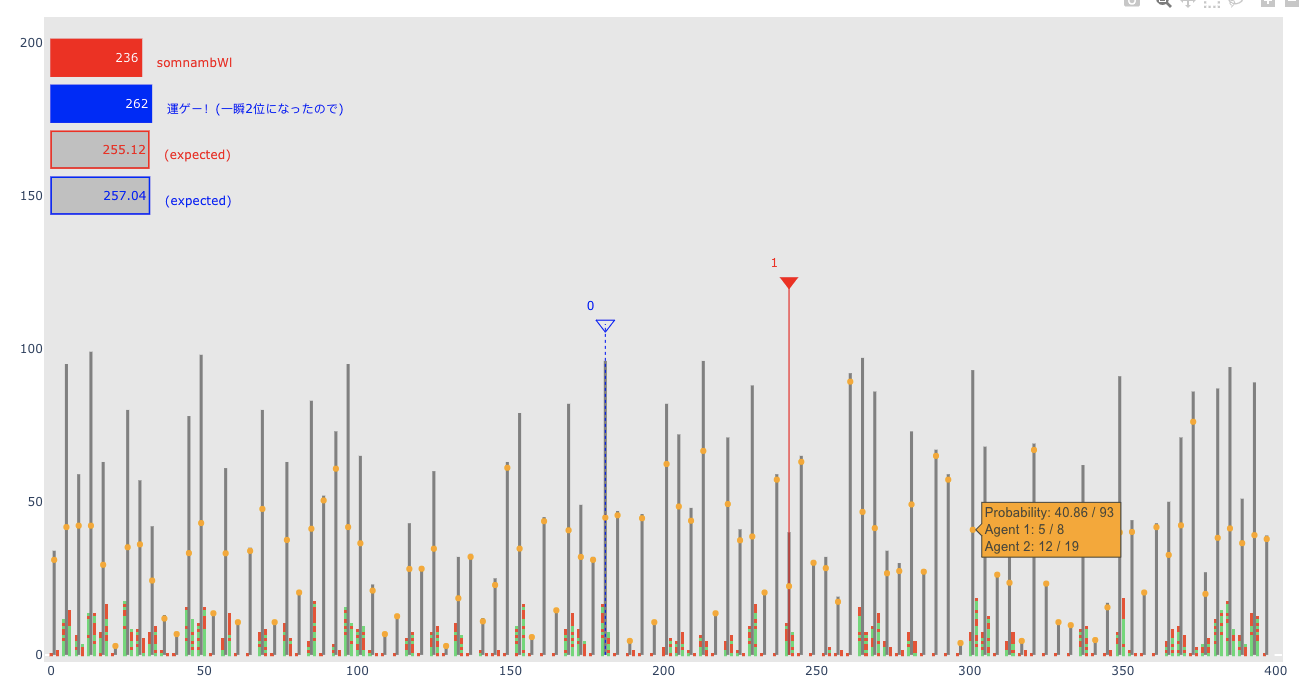

## Transforming data

In [ ]:
# Test that written version is working
from kaggle_environments import make

env = make("mab", debug=True)

env.run([None, "clever_elf.py"])

In [ ]:
def get_steps_from_json(json):
    df = pd.DataFrame().from_dict(json["steps"])
    df_1 = df[0].apply(pd.Series)[["action", "reward"]].rename({"action":"action_1", "reward":"total_reward_1"}, axis=1)
    df_2 = df[1].apply(pd.Series)[["action", "reward"]].rename({"action":"action_2", "reward":"total_reward_2"}, axis=1)
    dfa = pd.concat((df_1, df_2), axis=1).iloc[1:, :]
    dfa["reward_1"] = dfa["total_reward_1"] - dfa["total_reward_1"].shift(1)
    dfa["reward_2"] = dfa["total_reward_2"] - dfa["total_reward_2"].shift(1)
    dfa = dfa.fillna(0)
    dfa["reward_1"] = dfa["reward_1"].astype(int)
    dfa["reward_2"] = dfa["reward_2"].astype(int)
    return dfa[["action_1", "reward_1", "total_reward_1",
                "action_2", "reward_2", "total_reward_2"]]

def get_steps_until(final_step, steps_df, player):
    machines = defaultdict(lambda: [])
    for row in steps_df.iloc[0:final_step, :].iterrows():
        machines[row[1][f"action_{player}"]].append(row[1][f"reward_{player}"])
    return machines

In [ ]:
game_record = env.toJSON()

In [ ]:
# with open("./opponent.json") as json_file:
#     game_record = json.load(json_file)

# env = kaggle_environments.make(
#     "mab",
#     configuration=game_record["configuration"],
#     steps=game_record["steps"],
#     info=game_record["info"]
# )

In [ ]:
df = pd.DataFrame().from_dict(game_record["steps"])
thresholds = df[0].apply(pd.Series)["observation"].apply(pd.Series)["thresholds"].apply(pd.Series)

In [ ]:
steps_df = get_steps_from_json(game_record)

## Plotly

In [ ]:
def set_board_machines(board, machines, move_by, good_color=(72, 219, 111), bad_color=(245, 70, 39)):
    for m in range(100):
        for height, value in enumerate(machines[m]):
            if value == 0:
                board[height, m*4+move_by] = bad_color
            elif value == 1:
                board[height, m*4+move_by] = good_color    
    return board

def set_thresholds(board, step, thresholds, move_by, color=(0, 0, 120)):
    values = thresholds.iloc[step-1, :].values
    for position, height in enumerate(values):
        h = int(height)
        board[0:h, position*4+move_by] = color
    return board

In [ ]:
def make_traces(env, data, step, steps_df):
    
    board = np.ones((100,400,3)) * 231
    machines_1 = get_steps_until(step, steps_df, player=1)
    machines_2 = get_steps_until(step, steps_df, player=2)
    rewards_1 = [np.array(machines_1[i]).sum() for i in range(100)]
    tries_1 = [len(machines_1[i]) for i in range(100)]
    rewards_2 = [np.array(machines_2[i]).sum() for i in range(100)]
    tries_2 = [len(machines_2[i]) for i in range(100)]
    board = set_board_machines(board, machines_1, move_by=0)
    board = set_board_machines(board, machines_2, move_by=2)

    initial_thresholds = env.steps[0][0]["observation"]["thresholds"]
    current_thresholds = env.steps[step][0]["observation"]["thresholds"]
    actions = list(np.array([s["action"] for s in env.steps[step]])*4+1)
    rewards = list(np.array([s["reward"] for s in env.steps[step]]))

    if step > 0:
        last_rewards = [s["reward"] for s in env.steps[step - 1]]
    else:
        last_rewards = [0, 0]
        
    success = [1 if rewards[i] > last_rewards[i] else 0 for i in range(2)]
    
    text_offset = 20 if step < 300 else 5
    red = "red"
    blue = "blue"
    
    customdata = np.stack((np.around(np.array(current_thresholds), 2), np.array(initial_thresholds), 
                           np.array(rewards_1), np.array(tries_1), 
                           np.array(rewards_2), np.array(tries_2)), axis=-1)

    traces = [
        go.Image(name="reward_boxes", z=board, hoverinfo="skip"
        ),
        go.Scatter(
            name="agent0_line",
            x=[actions[0]] * 2,
            y=[0, 108],
            mode="lines",
            line=dict(color=blue, dash="solid" if success[0] else "dot", width=1),
            hoverinfo="skip",
        ),
        go.Scatter(
            name="agent1_line",
            x=[actions[1]] * 2,
            y=[0, 122],
            mode="lines",
            line=dict(color=red, dash="solid" if success[1] else "dot", width=1),
            hoverinfo="skip",
        ),
        go.Scatter(
            name="agent_indicators",
            x=actions*4,
            y=[108, 122],
            text=["0", "1"],
            textposition="top left",
            textfont=dict(color=[blue, red]),
            hoverinfo="skip",
            mode="markers+text",
            marker=dict(
                color=[blue, red],
                size=16,
                symbol=["triangle-down" if s else "triangle-down-open" for s in success],
            ),
        ),
        go.Bar(
            name="initial_thresholds",
            x=np.array(range(100))*4+1,
            y=initial_thresholds,
            marker_line_width=0,
            marker_color="grey",
            width=1,
            customdata=customdata,
            hovertemplate="<br>Probability: %{customdata[0]} / %{customdata[1]}\n"+\
            "<br>Agent 1: %{customdata[2]} / %{customdata[3]}\n"+\
            "<br>Agent 2: %{customdata[4]} / %{customdata[5]}\n<extra></extra>"
        ),
        go.Scatter(
            name="current_thresholds",
            x=np.array(range(100))*4+1,
            y=current_thresholds,
            mode="markers",
            marker_line_width=0,
            marker_color="orange",
            customdata=customdata,
            hovertemplate="<br>Probability: %{customdata[0]} / %{customdata[1]}\n"+\
            "<br>Agent 1: %{customdata[2]} / %{customdata[3]}\n"+\
            "<br>Agent 2: %{customdata[4]} / %{customdata[5]}\n<extra></extra>"
        ),
        go.Bar(
            name="rewards",
            x=[r / 8 for r in rewards],
            y=[180, 195],
            text=rewards,
            textposition="auto",
            marker_line_width=1.5,
            marker_line_color=[blue, red],
            marker_color=[blue, red],
            orientation="h",
            hoverinfo="skip",
        ),
        go.Scatter(
            name="team_names",
            x=[r / 8 + text_offset for r in rewards],
            y=[180, 195],
            text=env.info.get("TeamNames", [""] * 2),
            textposition="bottom right",
            textfont=dict(color=[blue, red]),
            mode="text",
            hoverinfo="skip"
        ),
        go.Bar(
            name="expected_rewards",
            x=[r / 8 for r in data["expected_rewards"][:, step]],
            y=[150, 165],
            text=["{:.2f}".format(x) for x in data["expected_rewards"][:, step]],
            textposition="auto",
            textfont=dict(color=[blue, red]),
            marker_line_width=1.5,
            marker_line_color=[blue, red],
            marker_color="silver",
            orientation="h",
            hoverinfo="skip",
        ),
        go.Scatter(
            name="expected_label",
            x=[r / 8 + text_offset for r in data["expected_rewards"][:, step]],
            y=[150, 165],
            text="(expected)",
            textposition="bottom right",
            textfont=dict(color=[blue, red]),
            mode="text",
            hoverinfo="skip",
        ),
    ]
    
    return traces

In [ ]:
def make_figure_widget(env, steps_df, n_traces=30):

    fig = go.FigureWidget()

    fig.update_xaxes(
        range=[-2, 402],
        zeroline=False,
        showgrid=False,
    )
    fig.update_yaxes(
        range=[-2, 208],
        zerolinecolor="white",
        showgrid=False,
    )
    fig.update_layout(
        showlegend=False,
        plot_bgcolor="rgb(231, 231, 231)",
        autosize=False,
        width=1600,
        height=700,
        margin=dict(l=10, r=10, b=10, t=30, pad=1),
    )
    
    # create a couple extra datasets
    action_histogram = np.zeros((2, 2000, 100), dtype=int)
    expected_rewards = np.zeros((2, 2000), dtype=float)
    for step_idx, step in enumerate(env.steps):
        if step_idx == 0:
            continue
        for agent_idx, agent in enumerate(step):
            action = agent["action"]
            thresholds = env.steps[step_idx - 1][0]["observation"]["thresholds"]
            expected_reward = np.ceil(thresholds[action]) / 101
            action_histogram[agent_idx, step_idx:, action] += 1
            expected_rewards[agent_idx, step_idx:] += expected_reward
            
    data = {
        "action_histogram": action_histogram,
        "expected_rewards": expected_rewards,
    }

    fig.add_traces(make_traces(env, data, 0, steps_df))

    return fig, data

In [ ]:
fig, data = make_figure_widget(env, steps_df)

In [ ]:
@interact(step=(0, 1999))
def interactive_display(step=0):
    fig.update(data=make_traces(env, data, step, steps_df))
fig